## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

import sys
sys.path.append('/home/jcollins')

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params, \
                                              jack_1_template
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [4]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae_bneck-1'
n_pc_points = 1000                # Number of points per model.
bneck_size = 1                 # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

Load Point-Clouds

In [5]:
import pandas as pd
numjets = 500000
numvalid = 50000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_2.h5")
rawdata = outstore.select("points",stop=numjets).values
rawdata = rawdata.reshape(numjets,1000,2)
all_pc_data = PointCloudDataSet(rawdata,copy=False)
validdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
validdata = validdata.reshape(numvalid,1000,2)
valid_pc_data = PointCloudDataSet(validdata,copy=False)
gc.collect()

27

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
train_params = default_train_params()
train_params['saver_step'] = 2
encoder, decoder, enc_args, dec_args = jack_1_template(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [7]:
conf = Conf(n_input = [n_pc_points, 2],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 1   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

Build AE Model.

In [8]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
encoder_conv_layer_0 conv params =  384 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("single_class_ae_bneck-1_2/Sum:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_2:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_3:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_2 FC params =  129 bnorm params =  2
Tensor("single_class_ae_bneck-1_2/encoder_dense_layer_2_bnorm/batchno

Train the AE (save output to train_stats.txt) 

In [ ]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout,held_out_data=valid_pc_data)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '6.7108', 'loss=', '0.078425058')
INFO:tensorflow:../data/single_class_ae_bneck-1/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Held Out Data :', 'forward time (minutes)=', '0.4561', 'loss=', '0.073985284')
('Epoch:', '0002', 'training time (minutes)=', '6.7911', 'loss=', '0.076603731')
INFO:tensorflow:../data/single_class_ae_bneck-1/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.
('Held Out Data :', 'forward time (minutes)=', '0.4626', 'loss=', '0.076104975')
('Epoch:', '0003', 'training time (minutes)=', '6.8036', 'loss=', '0.077366155')
('Held Out Data :', 'forward time (minutes)=', '0.4808', 'loss=', '0.074984584')
('Epoch:', '0004', 'training time (minutes)=', '6.9708', 'loss=', '0.077397657')
INFO:tensorflow:../data/single_class_ae_bneck-1/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.
('Held Out Data :', 'forward time (minutes)=', '0.4634', 'loss=', '0.0752

If you ran the above lines, you can reload a saved model like this:

In [ ]:
load_pre_trained_ae = True
restore_epoch = 6
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Get a batch of reconstuctions and their latent-codes.

Use any plotting mechanism such as matplotlib to visualize the results.

In [21]:
import ot
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

In [22]:
numload = 1000
latent_codes = np.array([])
for i in range(10):
    feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
    reconstructions = ae.reconstruct(feed_pc)[0]
    latent_codes = np.append(latent_codes,ae.transform(feed_pc))


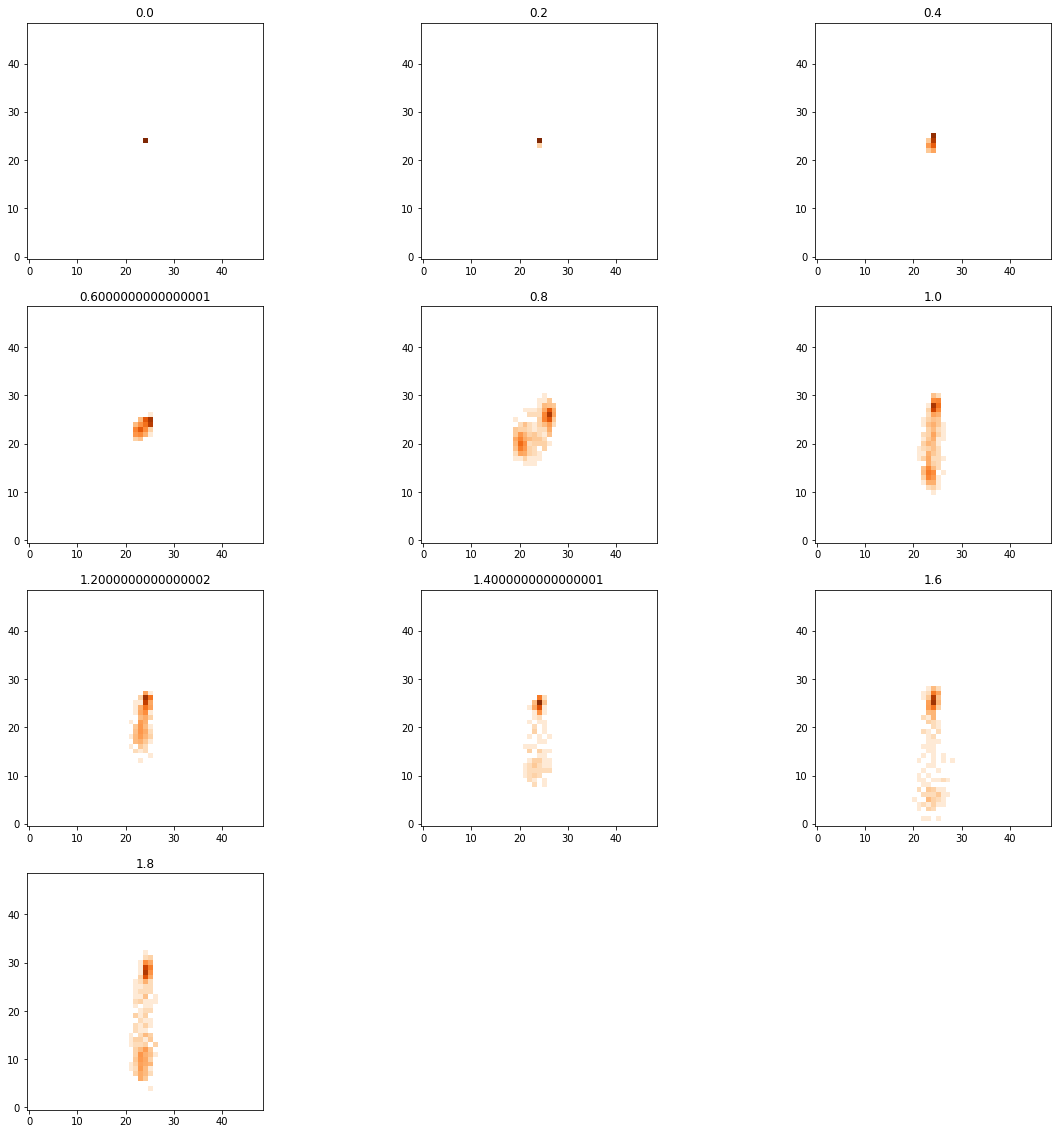

In [38]:
lim=1.8
bins=np.linspace(-lim, lim, 50)
codes = np.arange(0,2,0.2)
reconstructions=ae.decode(codes.reshape(-1,1))

plt.figure(figsize=[20,20])

for i, reconstruction in enumerate(reconstructions):
    plt.subplot(4,3,i+1)
    counts, bx, by = np.histogram2d(reconstruction[:,0],reconstruction[:,1],bins=bins)
    #print codes[i]
    plt.imshow(counts.T, norm=LogNorm(0.5, 1000), origin='lower',cmap='Oranges')
    plt.title(codes[i])
plt.show()

0.0


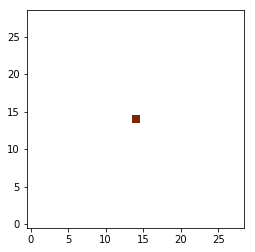

0.1


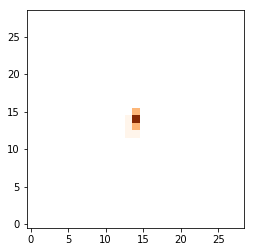

0.2


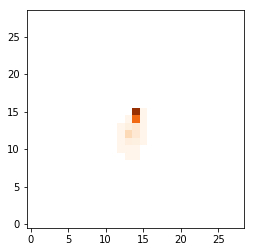

0.30000000000000004


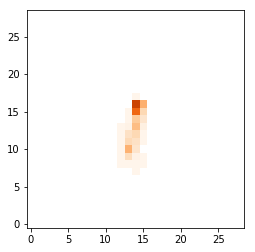

0.4


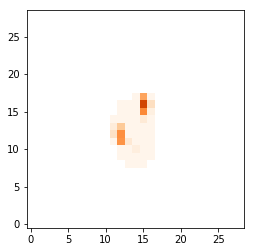

0.5


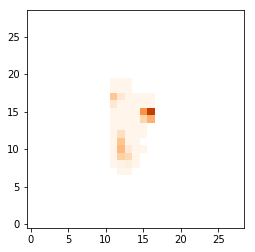

0.6000000000000001


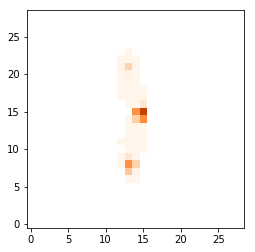

0.7000000000000001


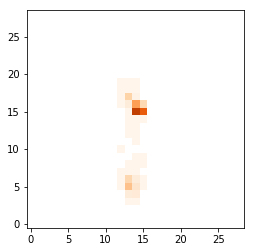

0.8


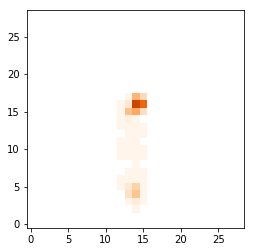

0.9


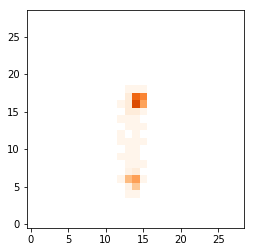

1.0


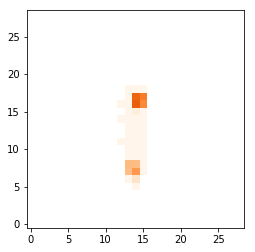

1.1


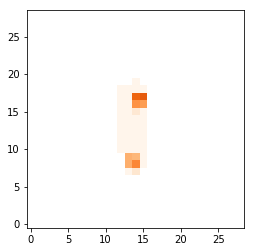

1.2000000000000002


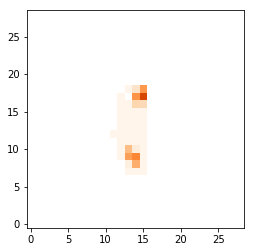

1.3


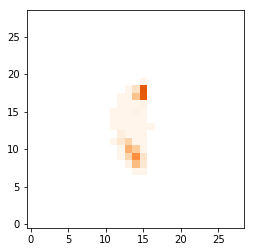

1.4000000000000001


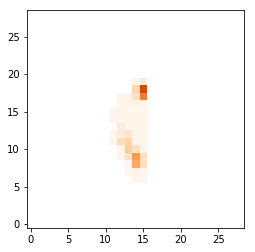

1.5


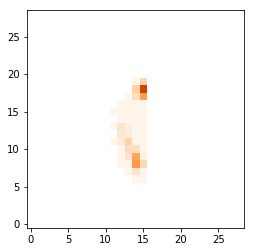

1.6


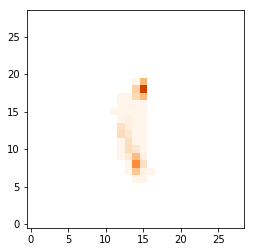

1.7000000000000002


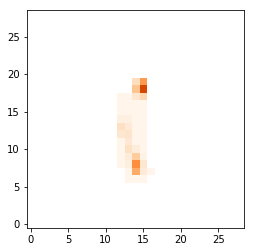

1.8


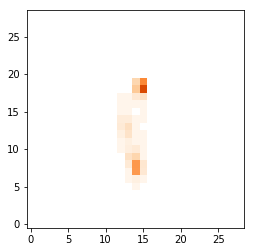

1.9000000000000001


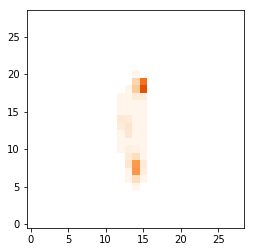

2.0


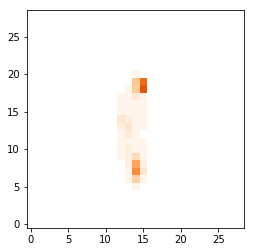

2.1


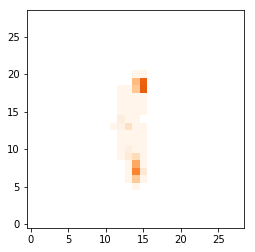

2.2


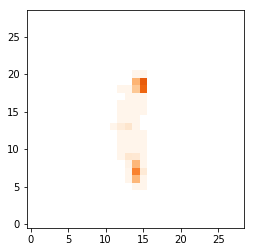

2.3000000000000003


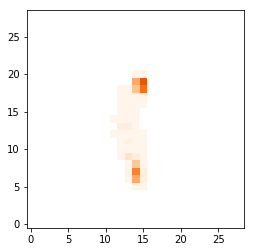

2.4000000000000004


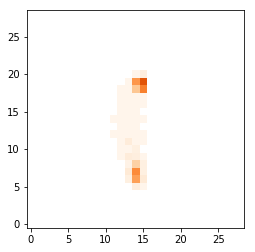

2.5


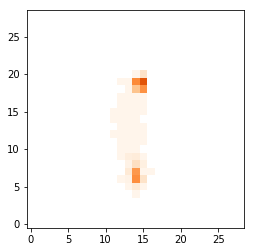

2.6


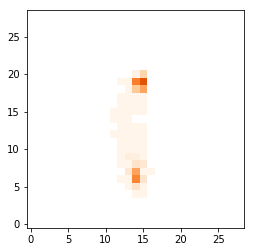

2.7


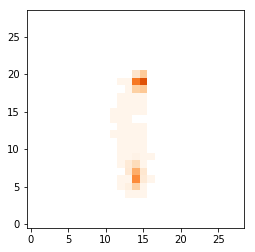

2.8000000000000003


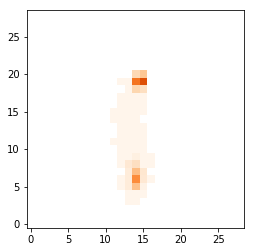

2.9000000000000004


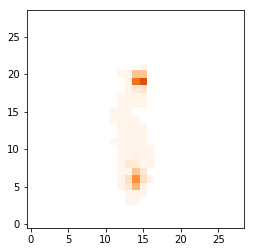

3.0


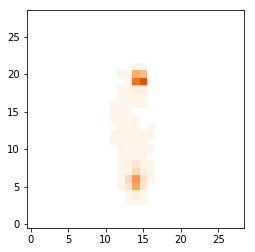

3.1


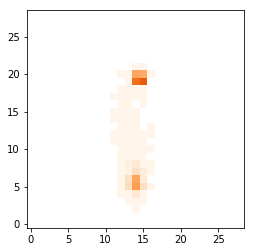

3.2


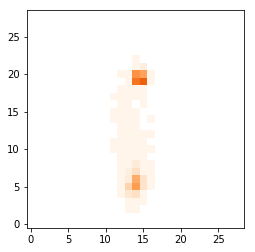

3.3000000000000003


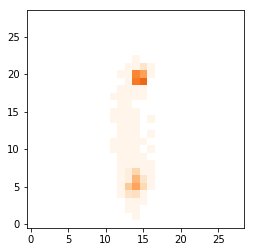

3.4000000000000004


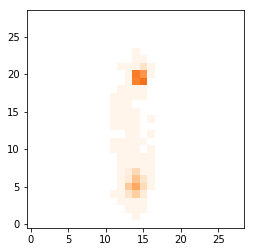

3.5


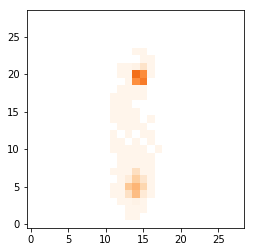

3.6


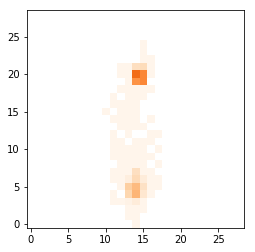

3.7


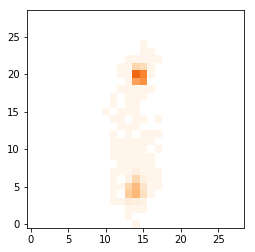

3.8000000000000003


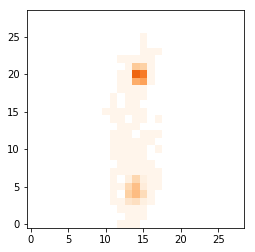

3.9000000000000004


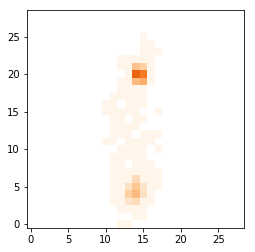

4.0


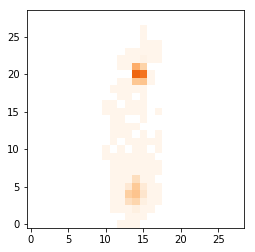

4.1000000000000005


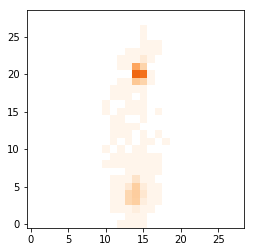

4.2


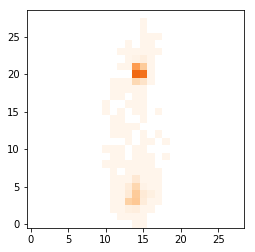

4.3


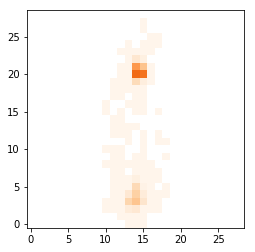

4.4


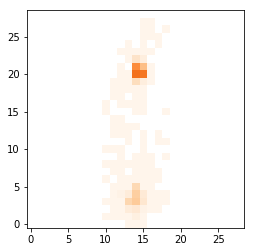

4.5


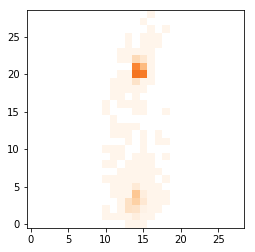

4.6000000000000005


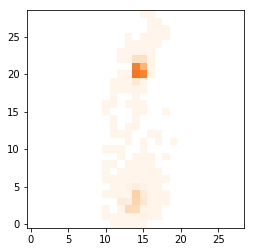

4.7


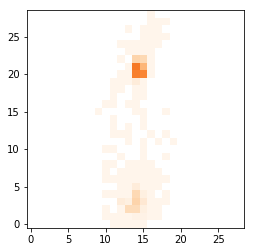

4.800000000000001


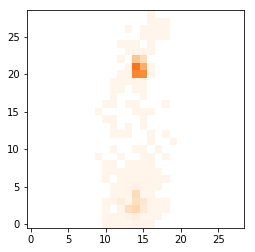

4.9


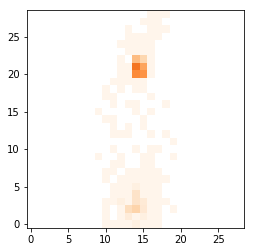

In [73]:
lim=1.5
bins=np.linspace(-lim, lim, 30)
codes = np.arange(0,5,0.1)
reconstructions=ae.decode(codes.reshape(-1,1))
for i, reconstruction in enumerate(reconstructions):
    counts, bx, by = np.histogram2d(reconstruction[:,0],reconstruction[:,1],bins=bins)
    print codes[i]
    plt.imshow(counts.T, norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [42]:
latent_codes

array([0.        , 0.        , 0.03275749, ..., 0.41804892, 1.15394378,
       0.44281441])

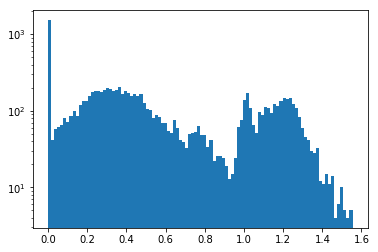

In [25]:
plt.hist(latent_codes,log=True,bins=100)
plt.show()

In [27]:
feed_pc[(latent_codes > 3).flatten()]

array([[[ 0.15117912,  0.51899798],
        [ 0.15117912,  0.51899798],
        [ 0.15117912,  0.51899798],
        ...,
        [-0.51889823, -0.56659679],
        [-0.34540676,  1.33818469],
        [ 0.28515141,  1.65355215]],

       [[ 0.02323104,  0.50055806],
        [ 0.02323104,  0.50055806],
        [ 0.02323104,  0.50055806],
        ...,
        [-0.55617046, -0.80430512],
        [-0.21198651, -0.77939099],
        [ 0.59863229, -0.69697795]],

       [[ 0.00460458,  0.63744757],
        [ 0.00460458,  0.63744757],
        [ 0.00460458,  0.63744757],
        ...,
        [-0.26617273, -0.85609188],
        [ 0.11119176,  0.56000794],
        [ 0.02646385,  1.32573275]],

       [[-0.13638911, -0.4763431 ],
        [-0.13638911, -0.4763431 ],
        [-0.13638911, -0.4763431 ],
        ...,
        [-0.68257552,  0.67236022],
        [ 0.11247785,  1.53431227],
        [-0.17352988,  1.76046049]],

       [[ 0.00582051,  0.66928363],
        [ 0.00582051,  0.66928363],
    

221.703052406


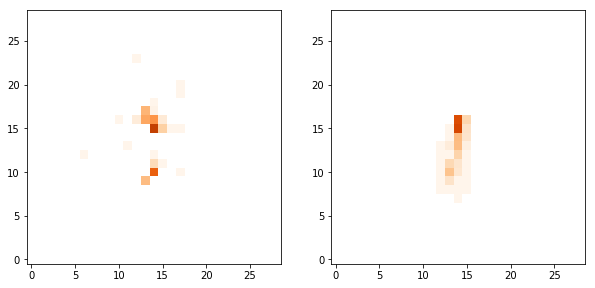

292.530850751


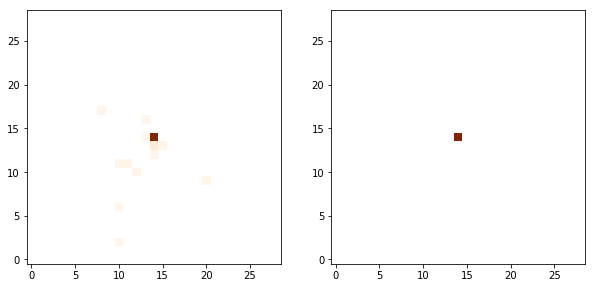

107.688384249


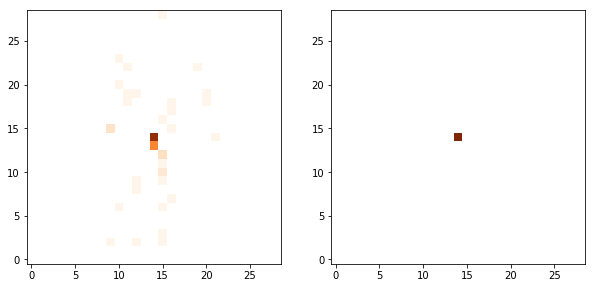

50.6748048036


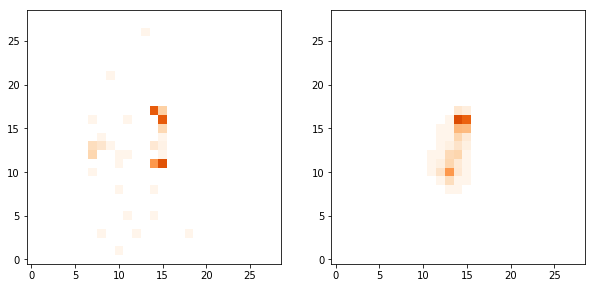

95.9185267949


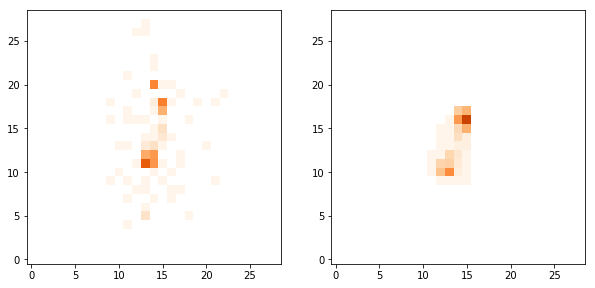

139.775521636


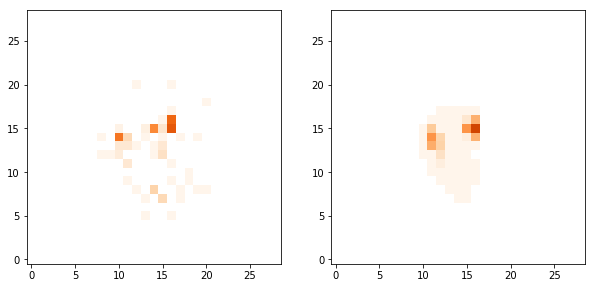

186.980790652


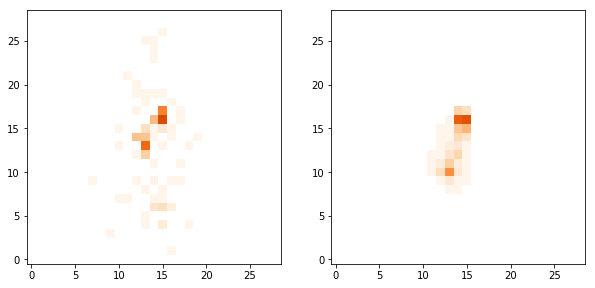

183.337019898


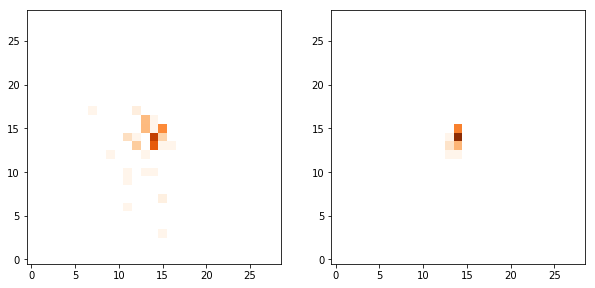

239.429186974


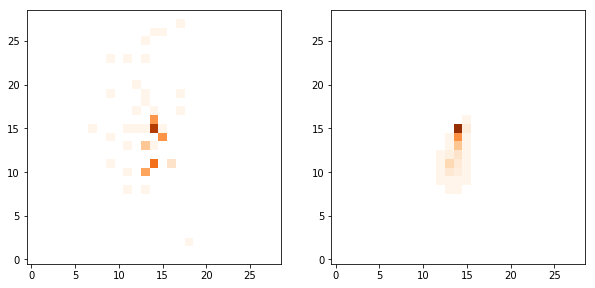

109.905211102


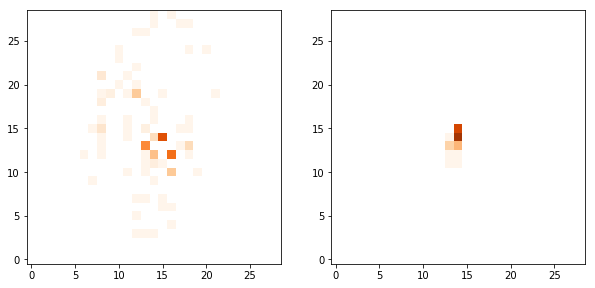

181.137814558


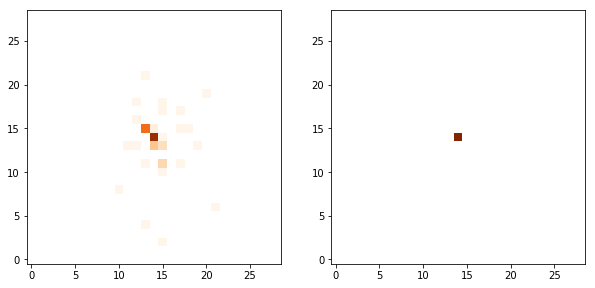

134.816497188


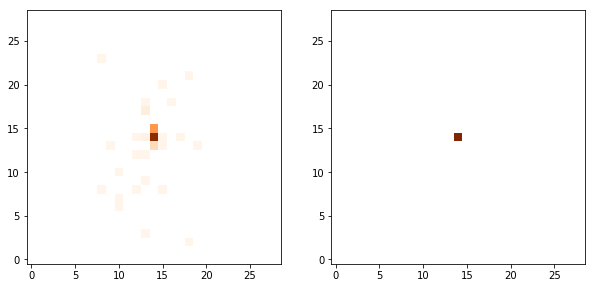

223.85727764


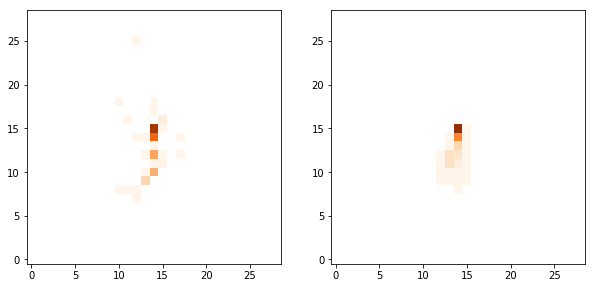

91.7353631625


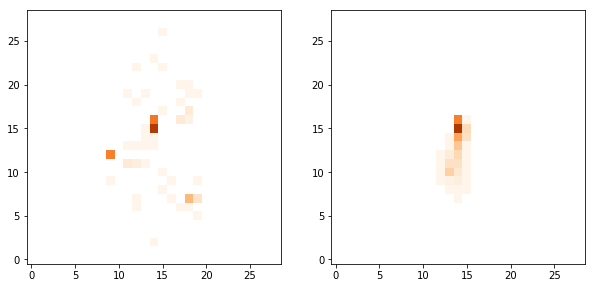

110.273040305


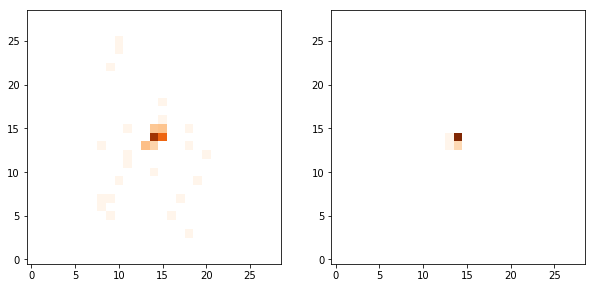

318.498102977


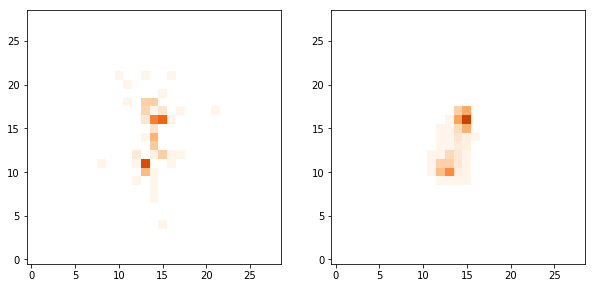

64.2110597806


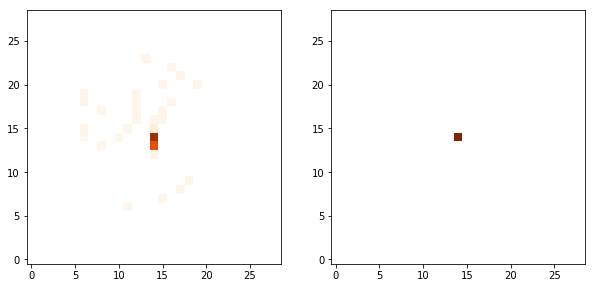

63.0272544451


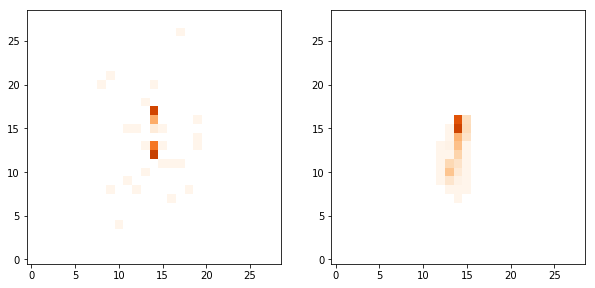

156.964429626


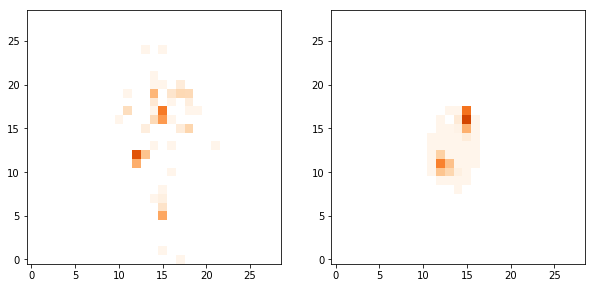

147.404566678


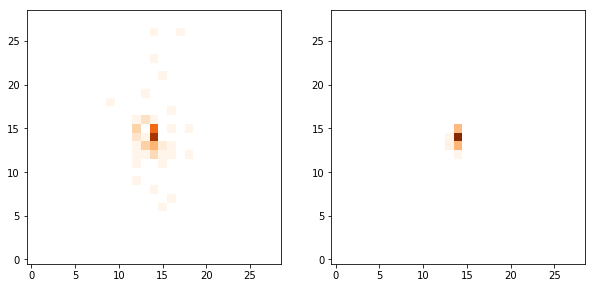

70.9403492225


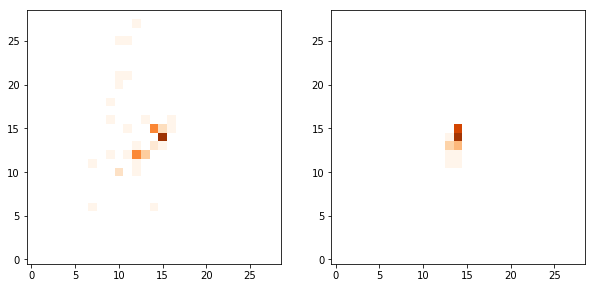

241.395480378


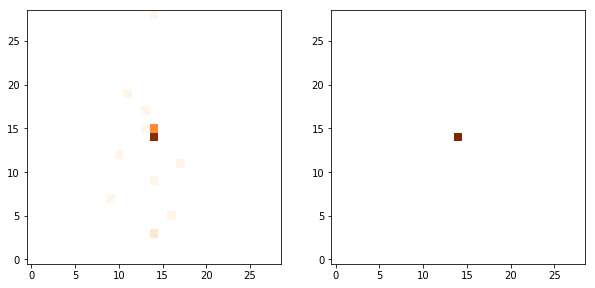

173.544883413


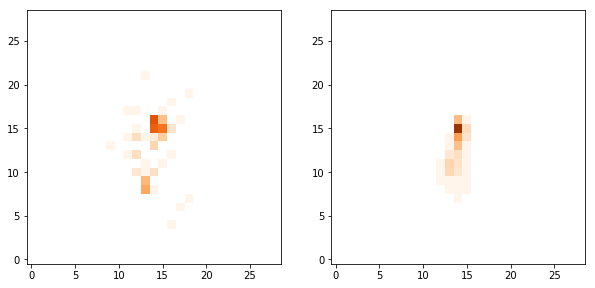

68.3585708864


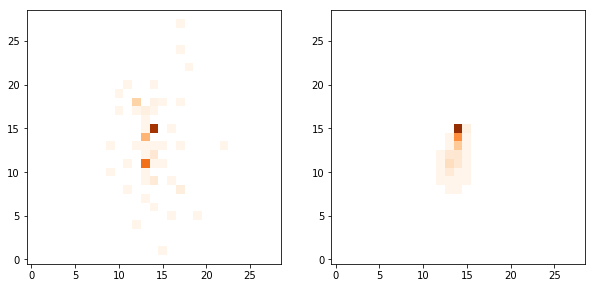

110.388753586


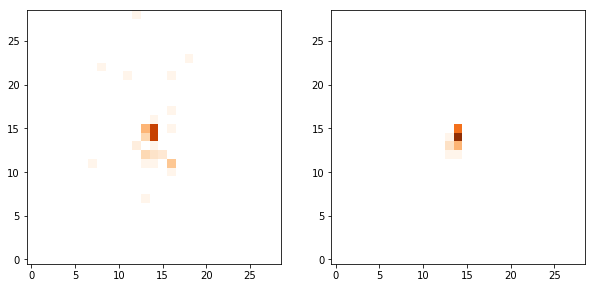

120.647891029


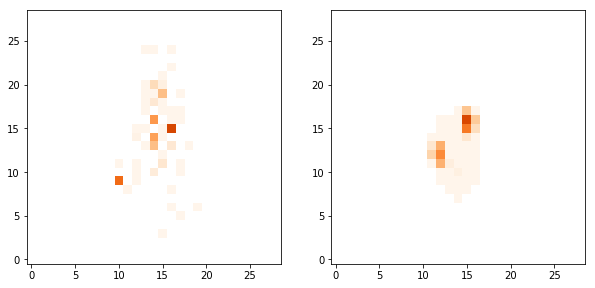

80.7129971775


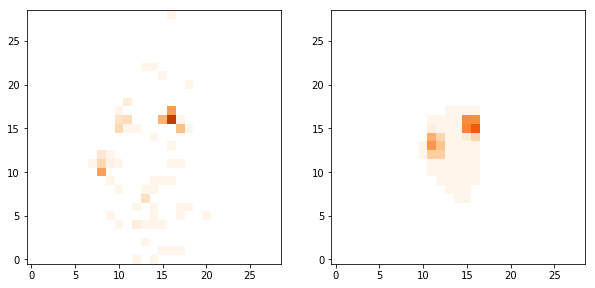

158.015296626


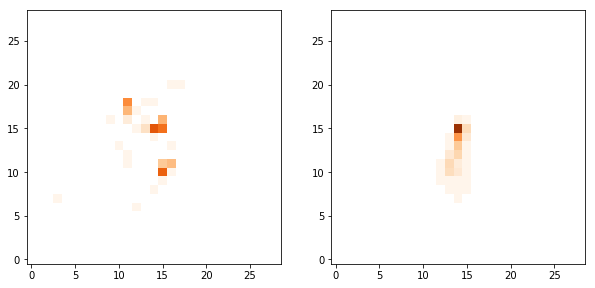

215.32267726


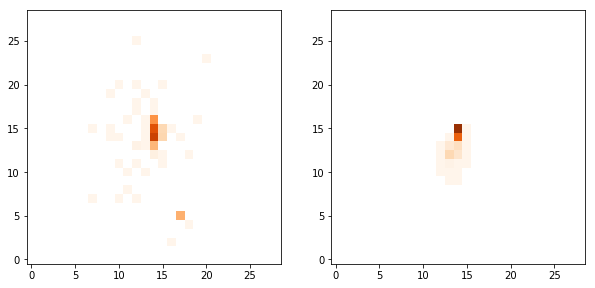

340.592831882


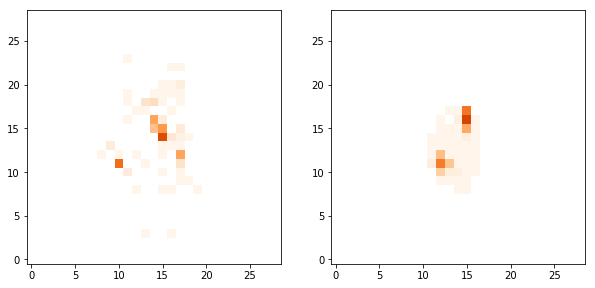

87.2224028048


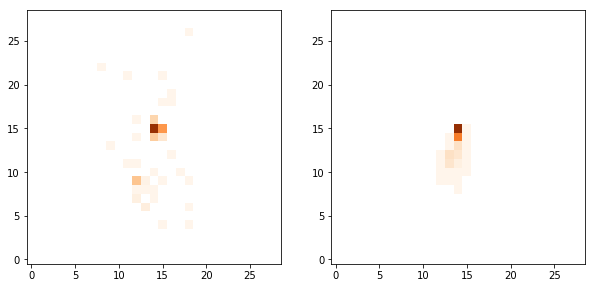

100.412415832


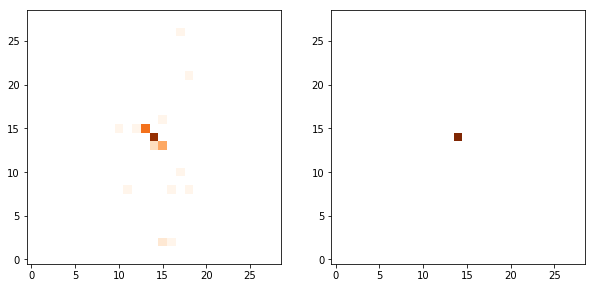

139.196386718


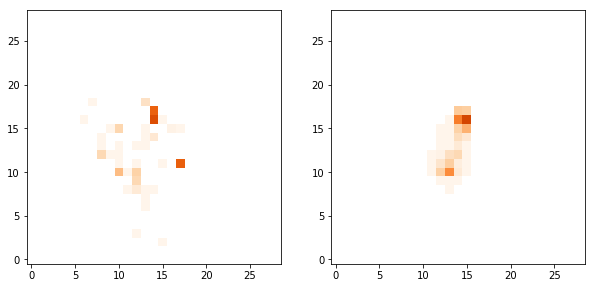

67.2136267066


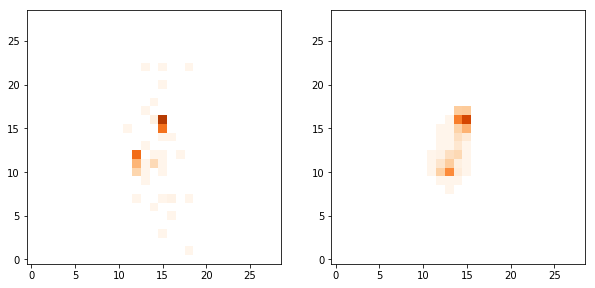

122.595942385


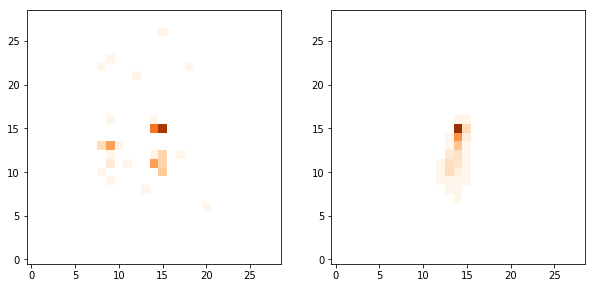

91.2182736461


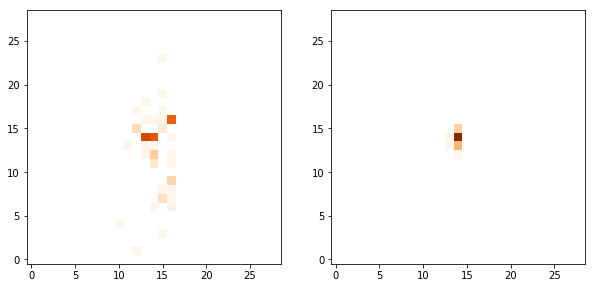

116.476436997


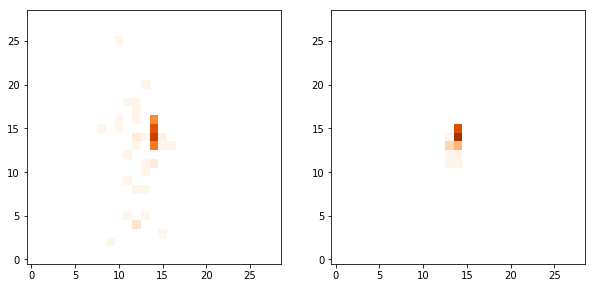

75.2928615557


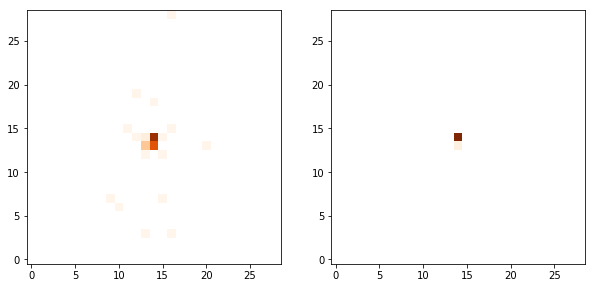

184.677847505


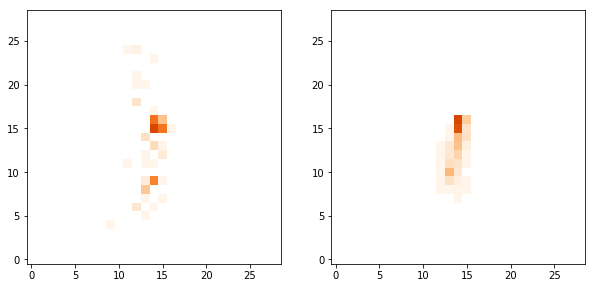

210.710870264


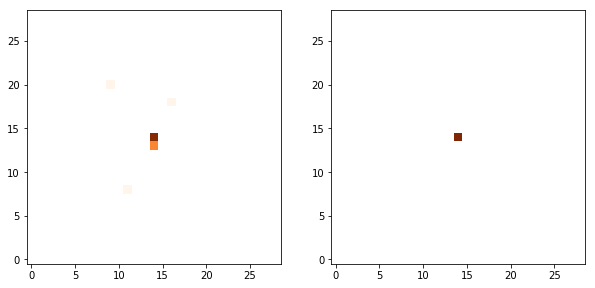

108.927026239


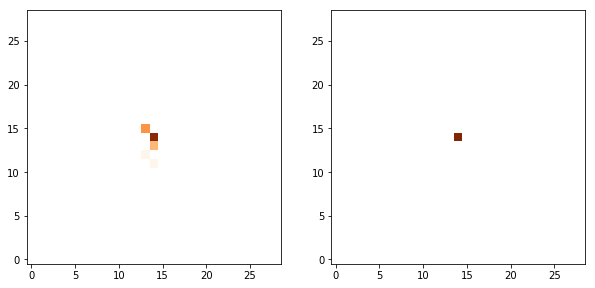

155.086260021


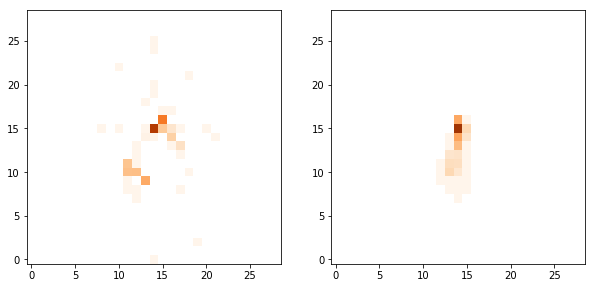

192.947732184


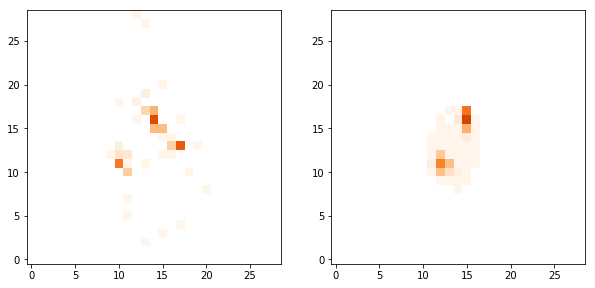

185.710909066


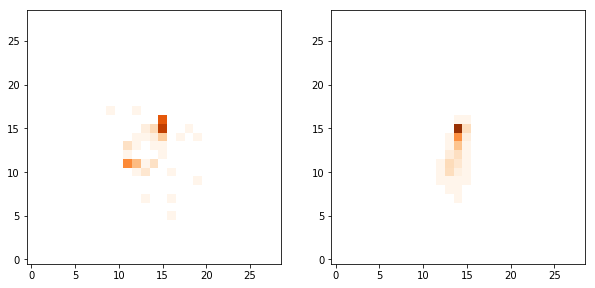

122.918074441


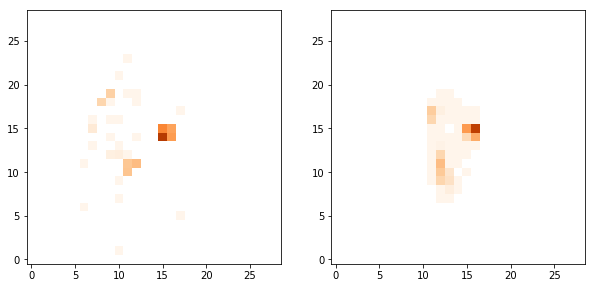

188.825116183


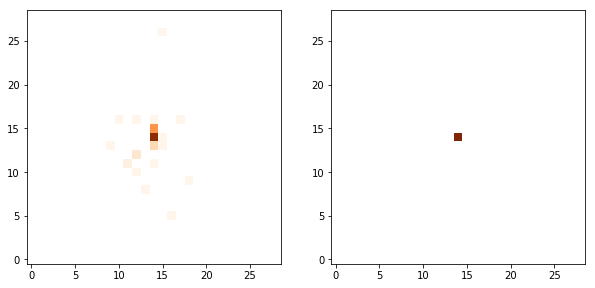

207.098475277


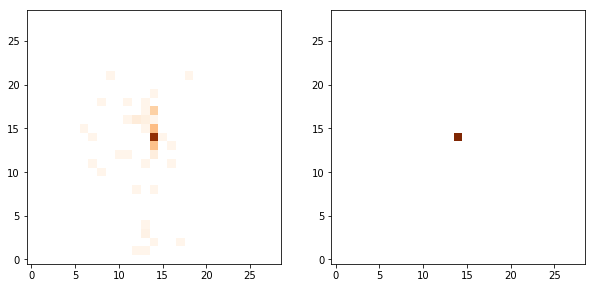

81.4933076587


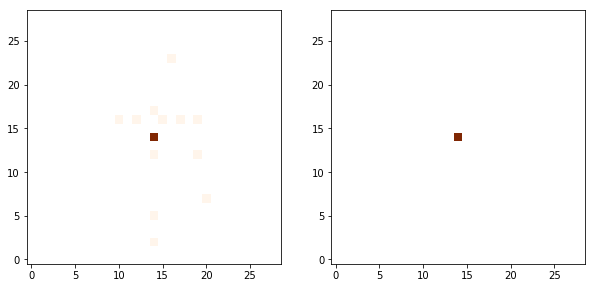

184.621500859


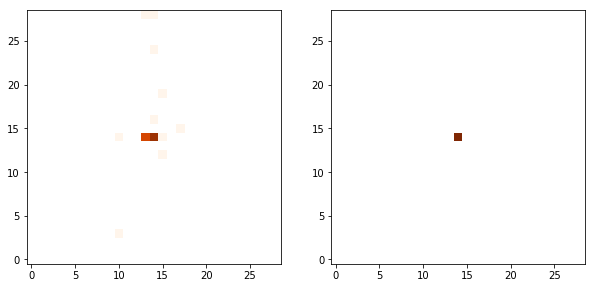

79.454200867


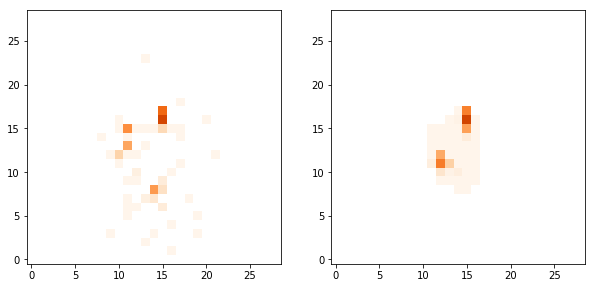

182.078864205


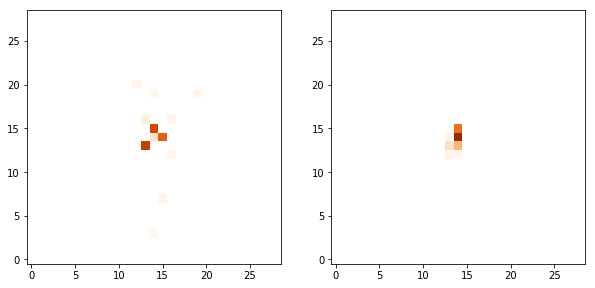

174.673835557


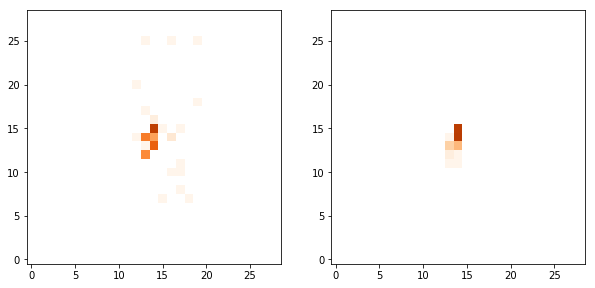

114.196725174


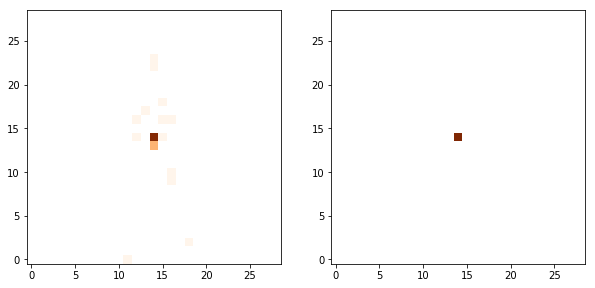

150.409364


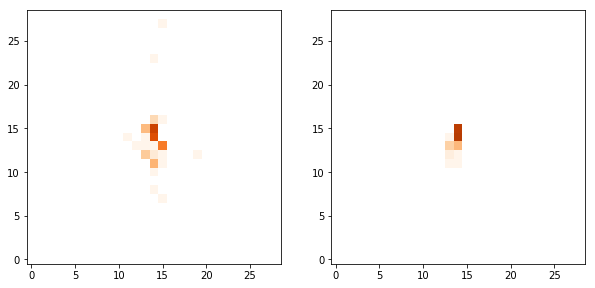

211.055621579


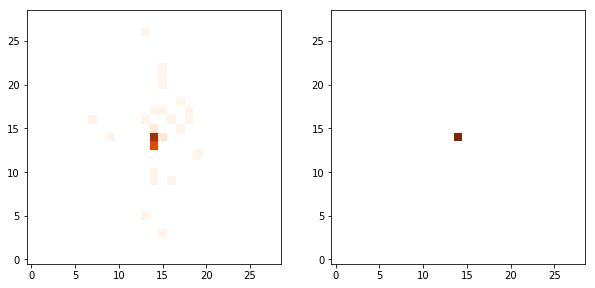

99.1469991111


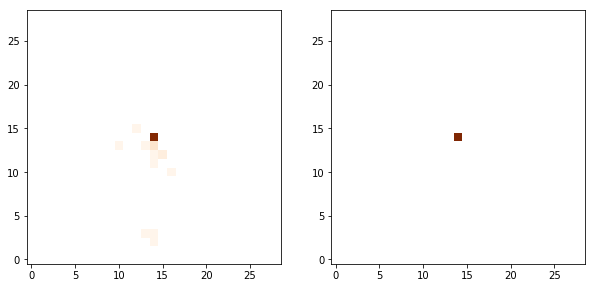

81.7058470154


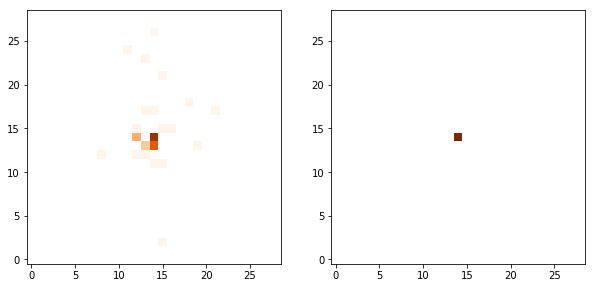

189.122859301


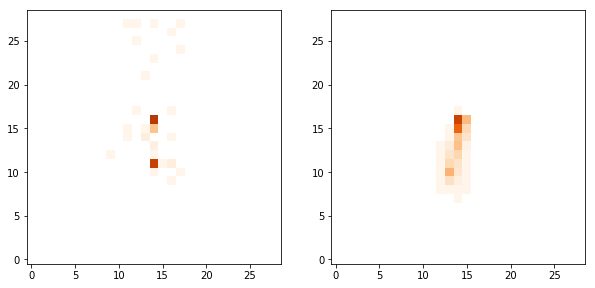

137.943573258


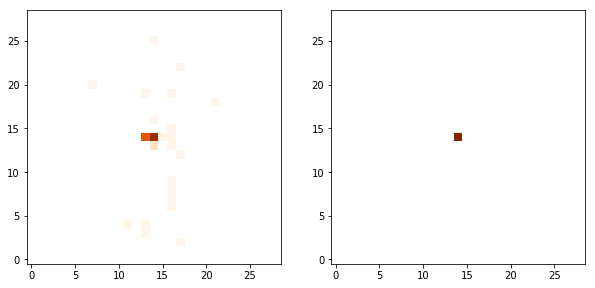

186.494547622


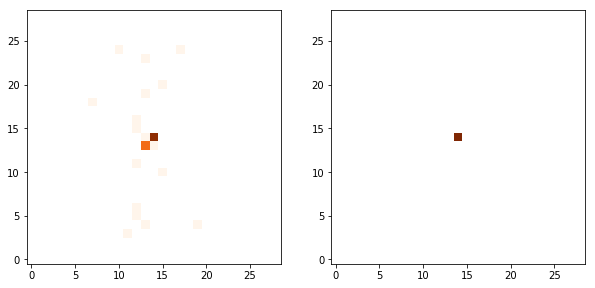

93.1488441099


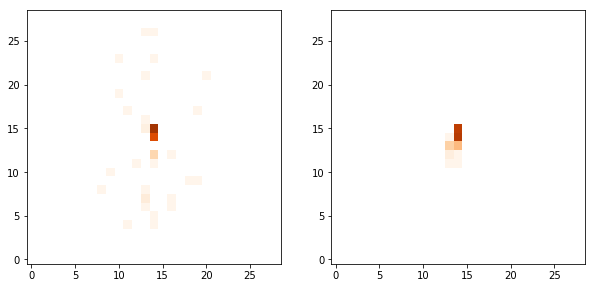

44.7039915097


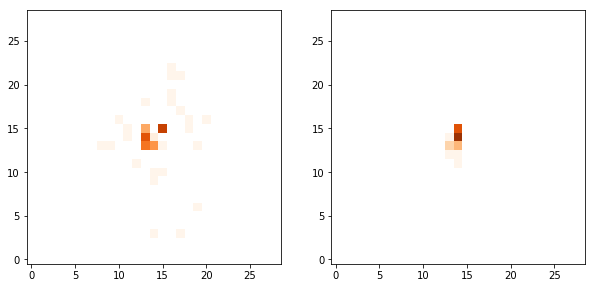

86.6279634153


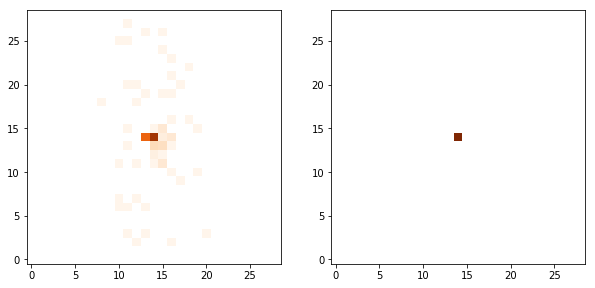

96.2958566987


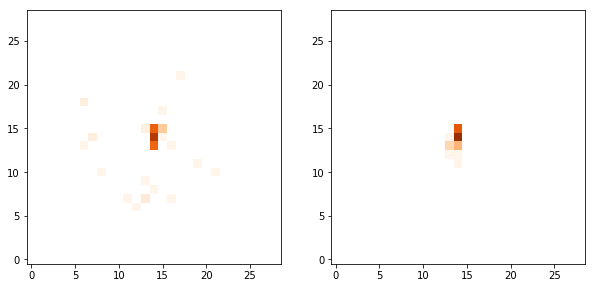

93.9558918271


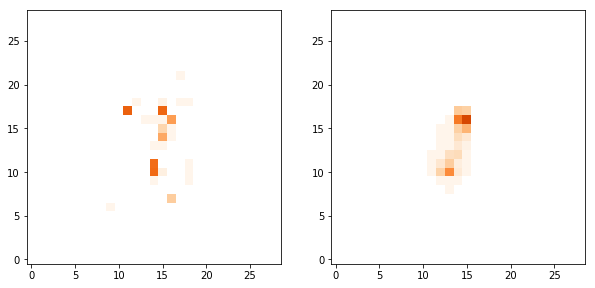

KeyboardInterrupt: 

In [33]:
feed_pc_new = feed_pc[(latent_codes < 0.5).flatten()][:50]
reconstructions_new = reconstructions[(latent_codes < 0.5).flatten()][:50]

countcut=0.5
lim=1.5
bins=np.linspace(-lim, lim, 30)

for i in range(len(feed_pc)):
    

    M = np.sqrt(ot.dist(feed_pc[i],reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    counts, bx, by = np.histogram2d(feed_pc_new[i][:,0],feed_pc_new[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[0].imshow(counts.T , norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions_new[i][:,0],reconstructions_new[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[1].imshow(counts.T, norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [46]:
points1 = reconstructions[:100]
points2 = feed_pc[:100]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])
print truecost
print time.time()-start

print np.average(truecost)
print np.std(truecost)

[182.23980839 105.88811728  80.09189931 233.25677398 141.98457377
 242.5938264   84.12414221 182.62578467  91.12047716 110.43642777
  79.50108092  80.29037319 175.65329244  35.32337919  48.98747612
  89.9689776   98.05422707  87.9487634  145.65039682  71.14173505
 148.0742106   81.37653945 213.38679569  40.0514369  134.81233692
 195.39957647 161.8791654   94.81980526 176.50463305 110.05886831
 201.63531792 133.18384201  69.99061484  57.94846601 216.16178187
 116.96076968 107.94867137 226.59515409 252.71148491 161.58383325
  89.15401524 225.43620467 367.90231331 189.16625764  64.59382257
  39.10490211 225.43009584 162.93132315 187.587114   228.11836814]
7.20111918449
140.9477850679615
69.5114604323645


In [33]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch

nclouds = 1
npoints = 1000
ndim=2

points1 = reconstructions[:10]
points2 = feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)
    print np.array(cost)
    
print time.time()-start

[117.658714  56.236546  89.34245   66.80762  263.8343   341.26456
 384.5187   113.77804  284.36197   94.092575]
3.73918485641


In [35]:
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])
print time.time()-start
print truecost

1.47339701653
[103.43814088  52.91713431  77.38923203  64.89898091 240.94020679
 314.66513298 356.61761806 105.20479831 255.41442598  84.57768313]


In [36]:
print (np.array(cost) - np.array(truecost))/np.array(truecost)

[0.13747901 0.06272848 0.15445587 0.02940934 0.09501977 0.08453248
 0.07823811 0.08149096 0.11333558 0.11249885]


247.508801076


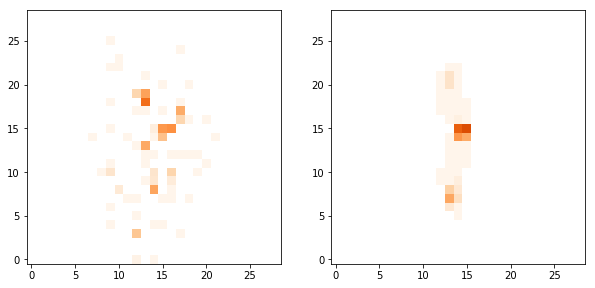

146.603469295


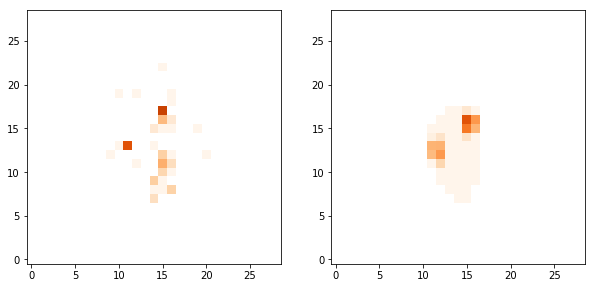

189.630652386


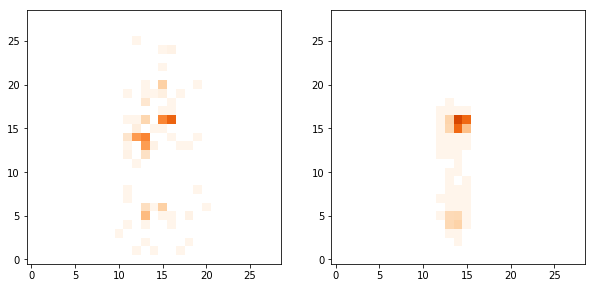

121.908145102


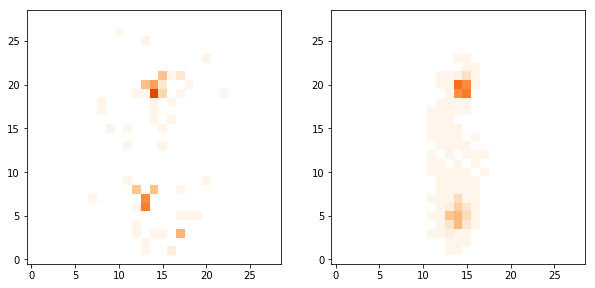

141.000114812


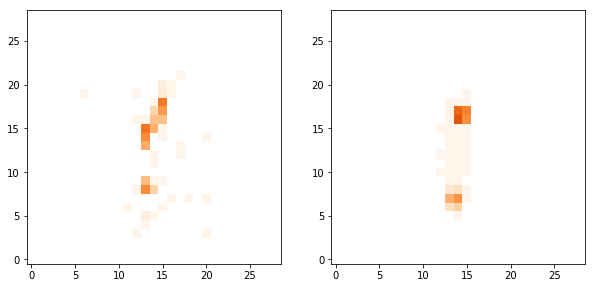

159.484384237


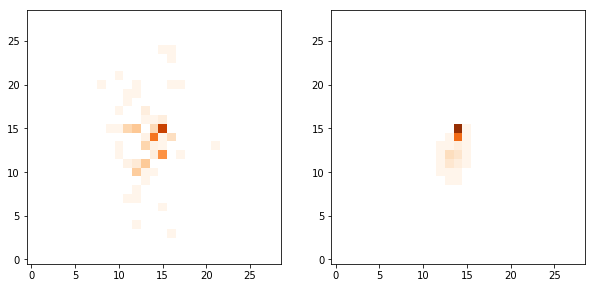

64.3159956183


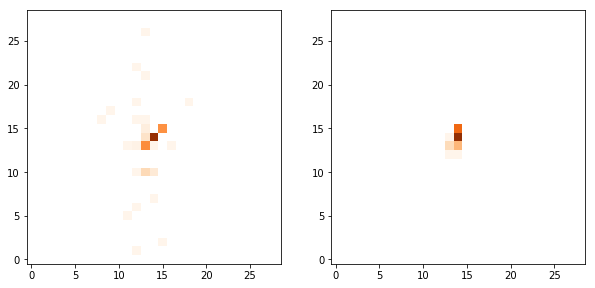

161.021078326


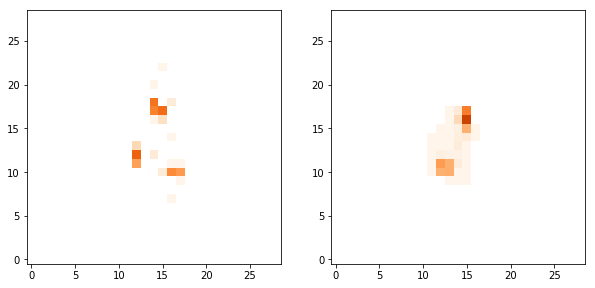

120.234964459


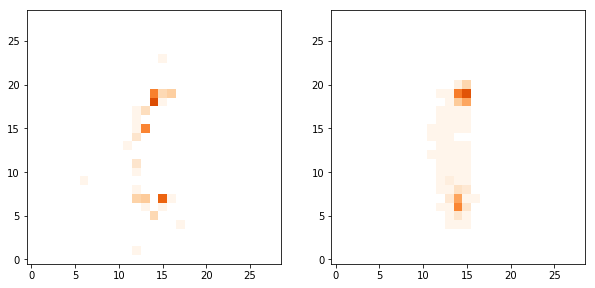

77.9142635582


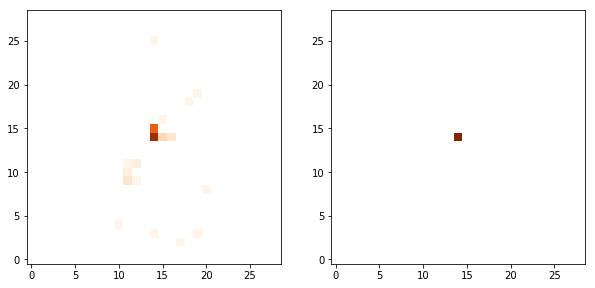

135.372826305


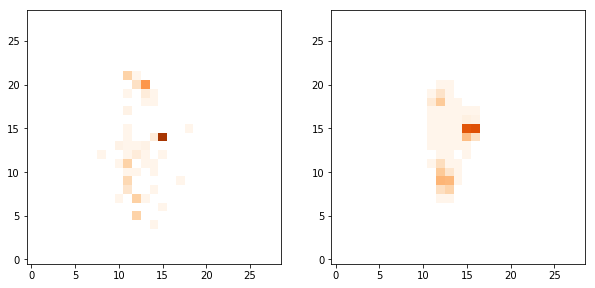

135.893753573


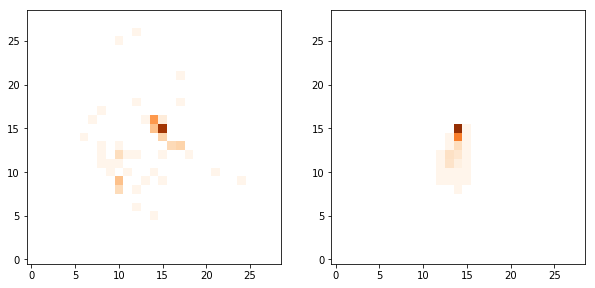

135.865557961


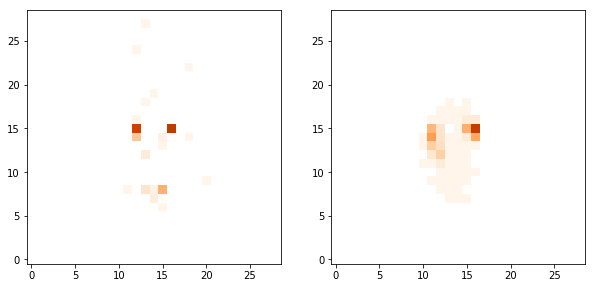

100.446910522


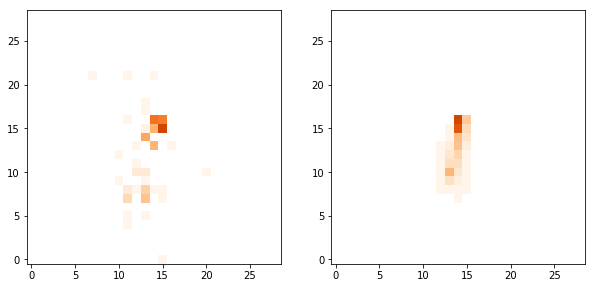

158.081026742


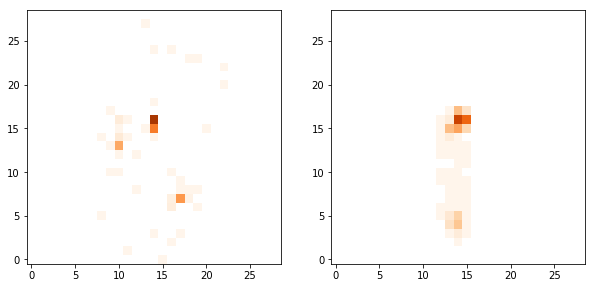

82.4238881379


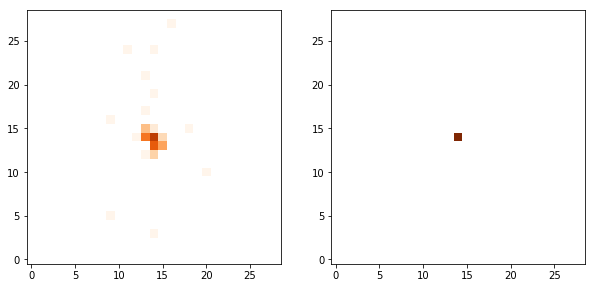

111.063373119


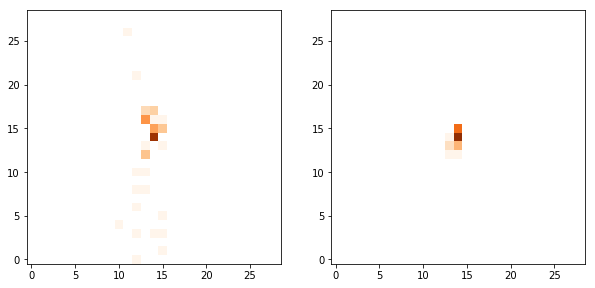

25.7341111432


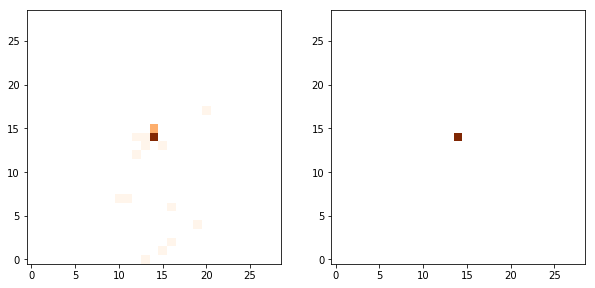

192.10265165


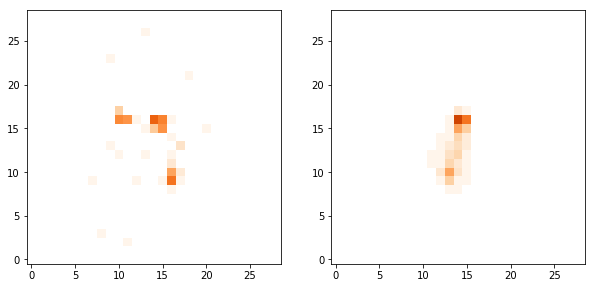

163.56182251


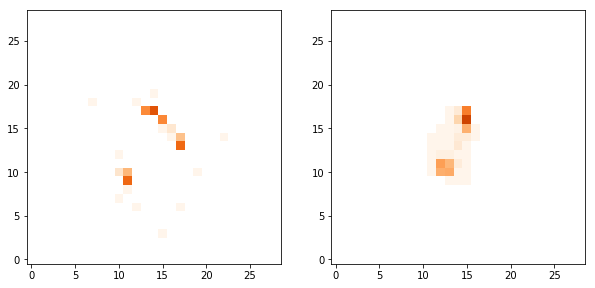

81.9075908439


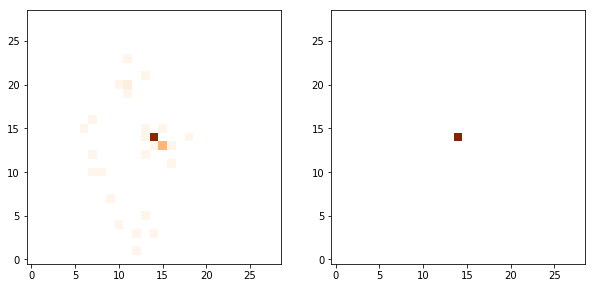

57.0897270924


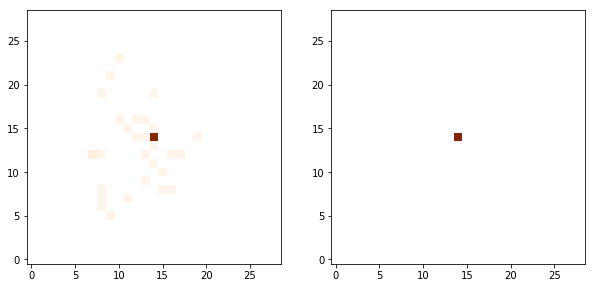

164.68634096


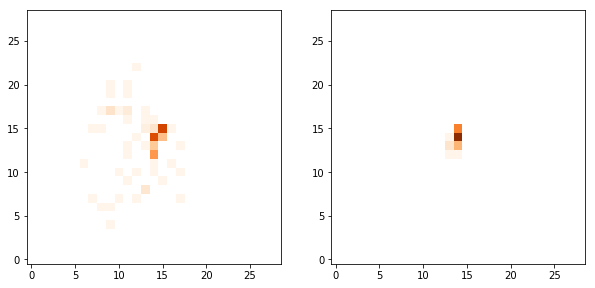

137.296537661


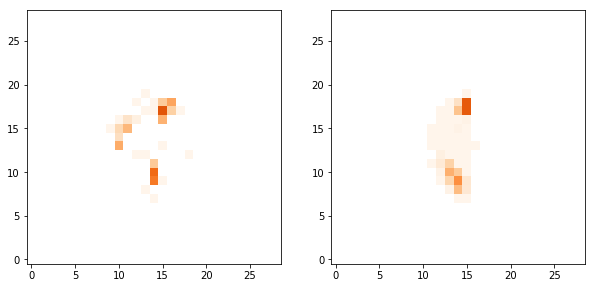

57.2708565785


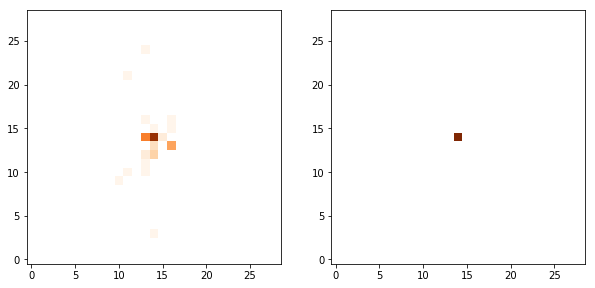

105.614302181


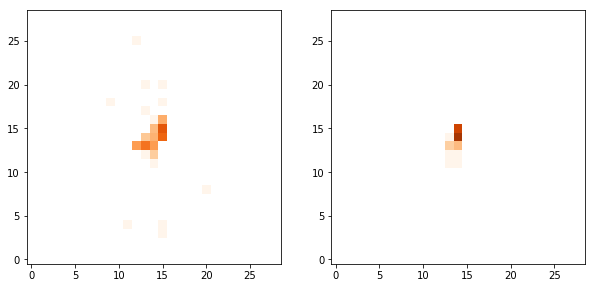

180.562642968


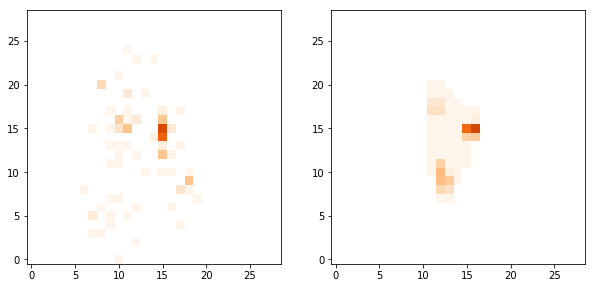

118.792731258


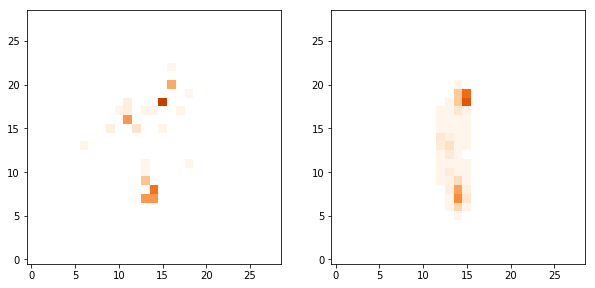

143.136598196


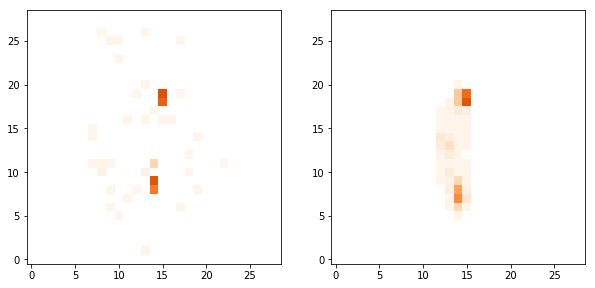

42.7805478184


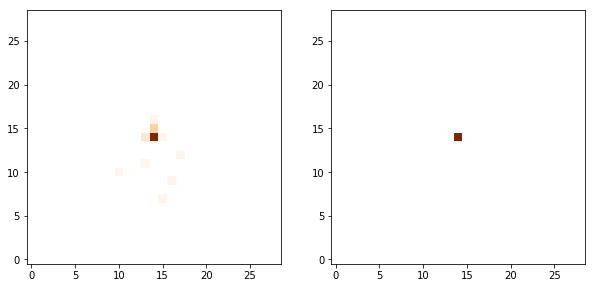

282.867105386


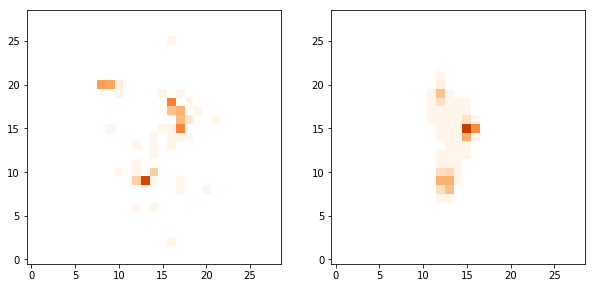

140.456948571


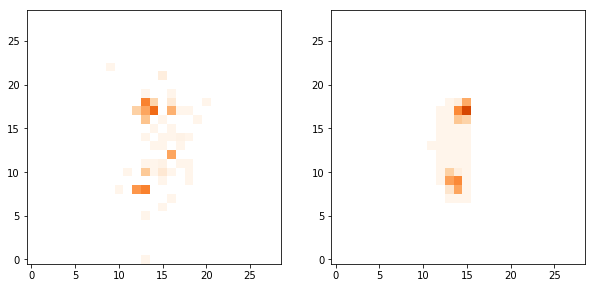

271.532620848


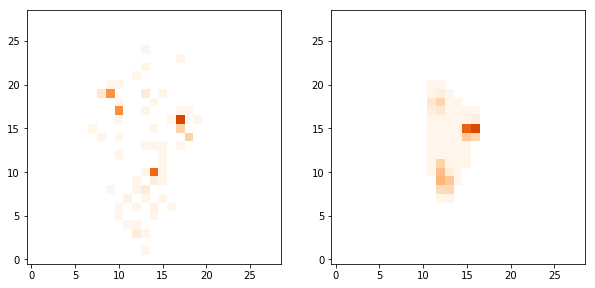

147.46805484


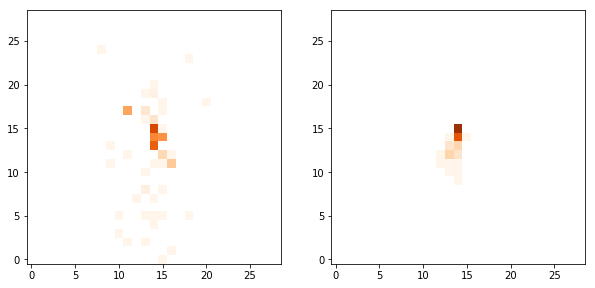

27.1156223275


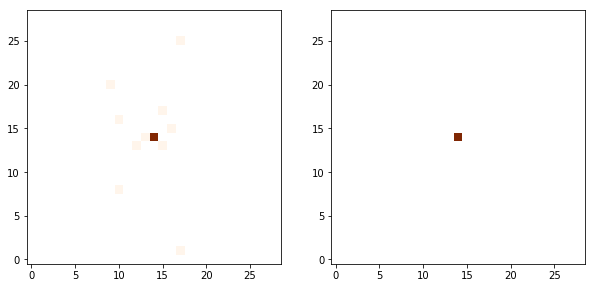

126.255185448


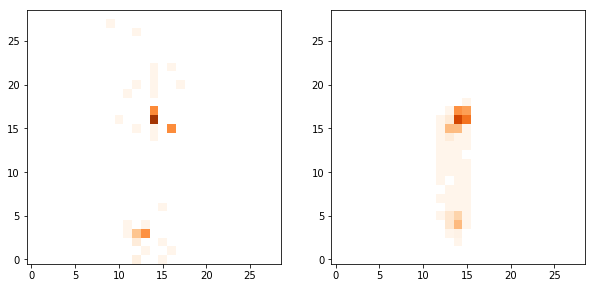

162.781729353


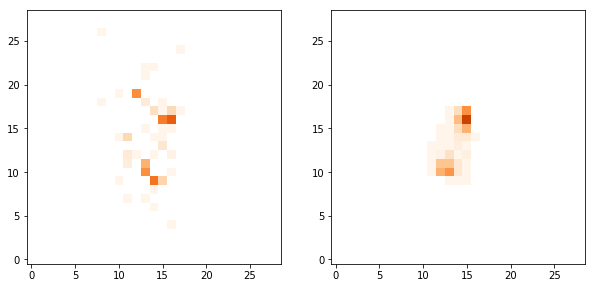

114.437273685


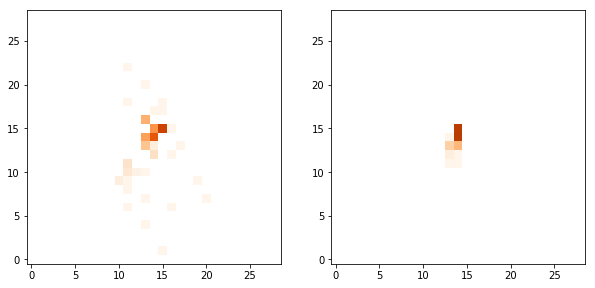

115.246035132


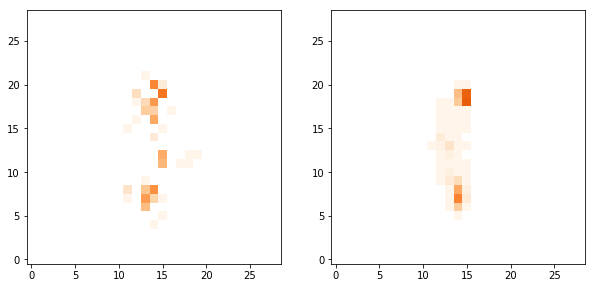

105.89605876


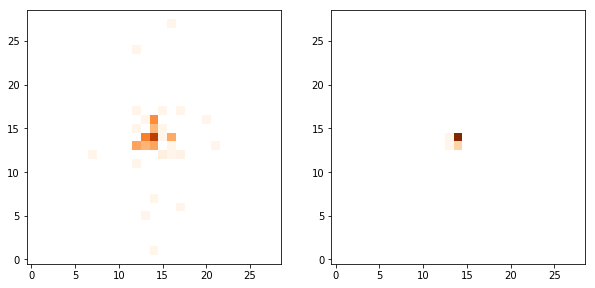

112.508506507


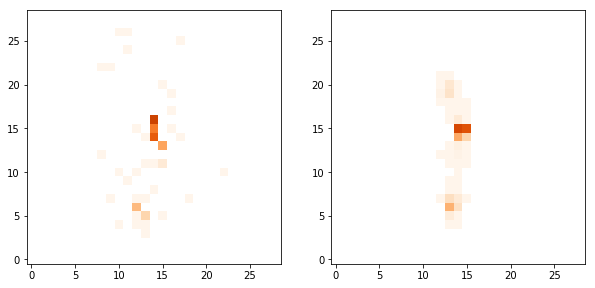

134.019695024


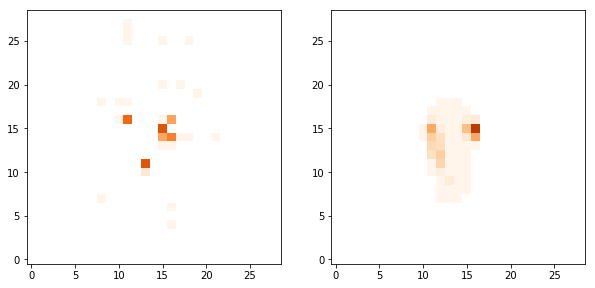

138.591973942


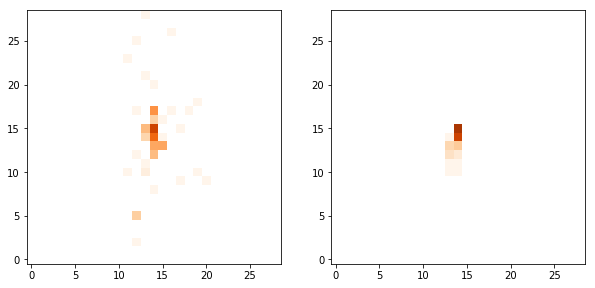

213.546806981


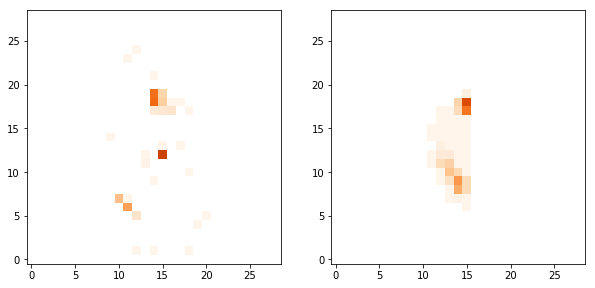

106.418947066


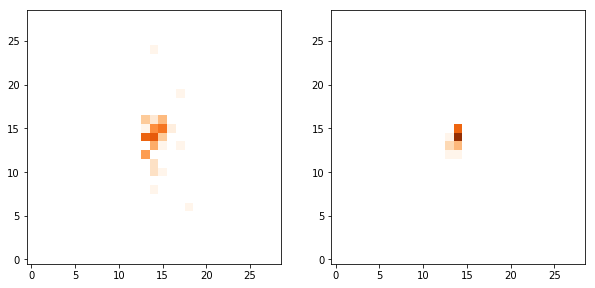

95.9747237713


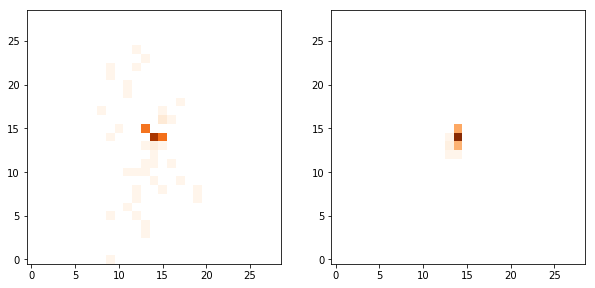

278.606345825


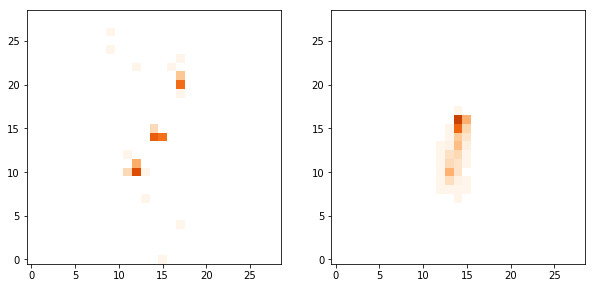

30.4204803552


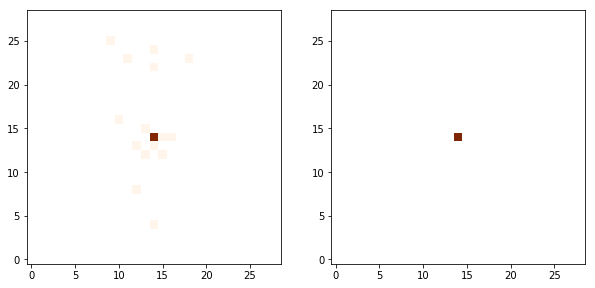

191.796045655


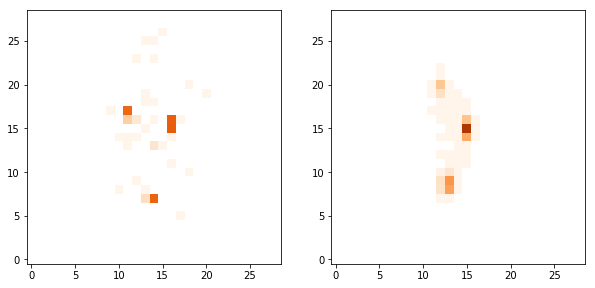

103.971230837


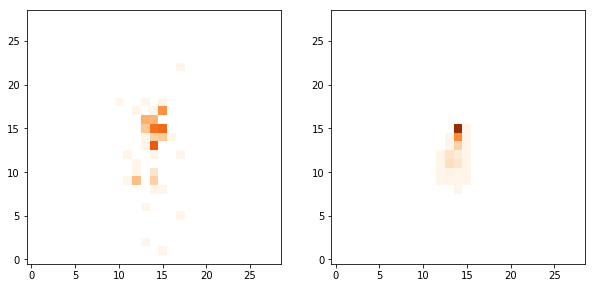

In [39]:
countcut=0.5
lim=1.5
bins=np.linspace(-lim, lim, 30)

for i in range(len(feed_pc)):
    

    M = np.sqrt(ot.dist(feed_pc[i],reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[0].imshow(counts.T , norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions[i][:,0],reconstructions[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[1].imshow(counts.T, norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [15]:
import pandas as pd
numtops = 10000

topstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top.h5")
toprawdata = topstore.select("points",stop=numtops).values
toprawdata = toprawdata.reshape(numtops,1000,2)

top_pc_data = PointCloudDataSet(toprawdata)

numload = 50
feed_pc, feed_model_names, _ = top_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]

117.876048835


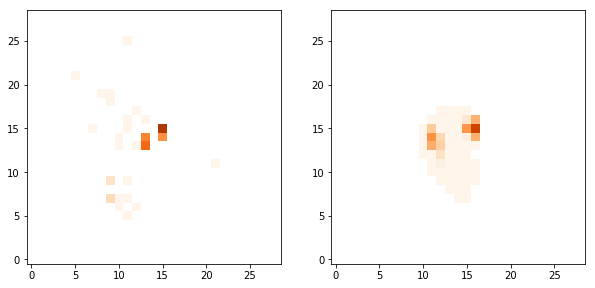

228.578341531


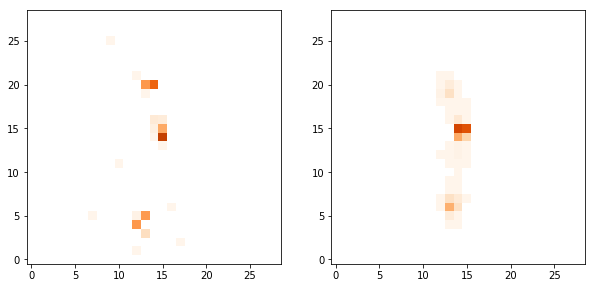

226.899353393


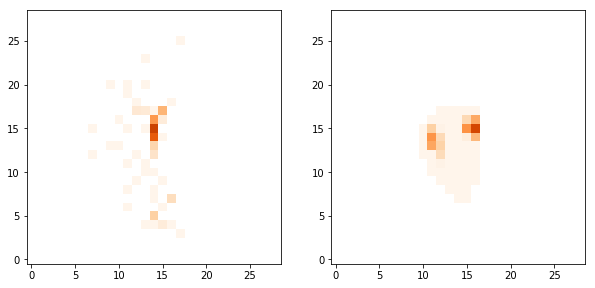

75.4005728207


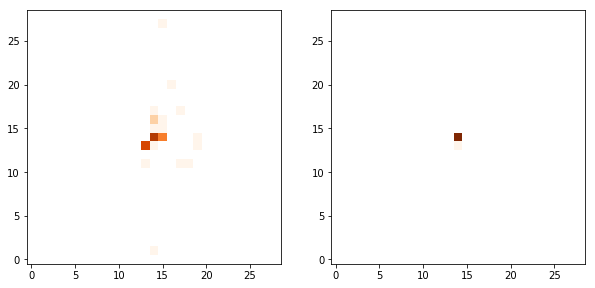

100.98073015


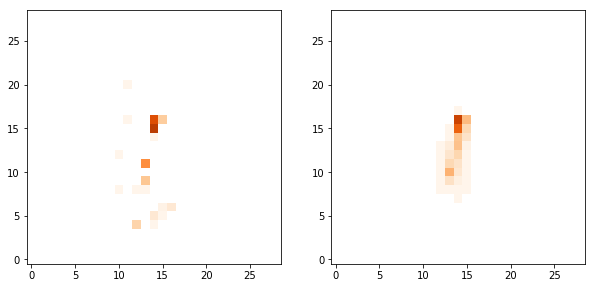

144.599615267


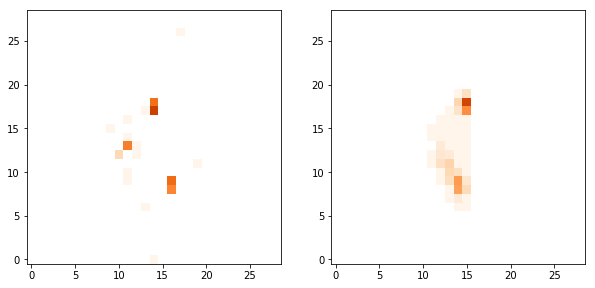

149.50867579


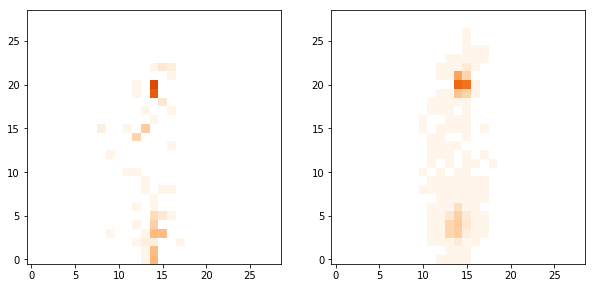

312.030561259


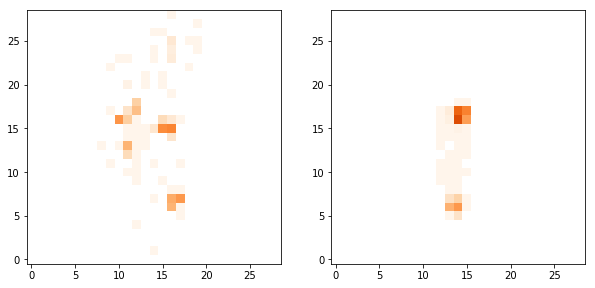

123.417186793


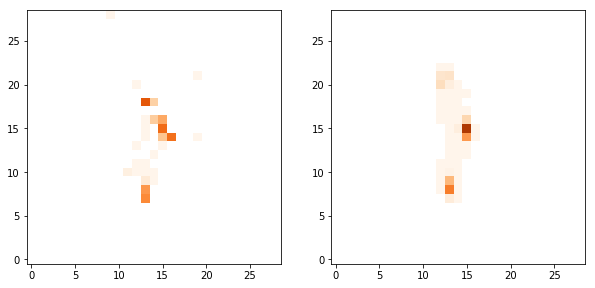

145.085908689


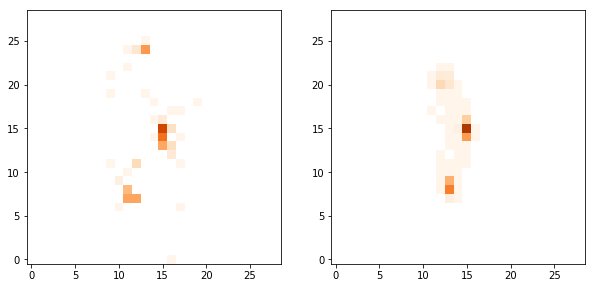

118.322875725


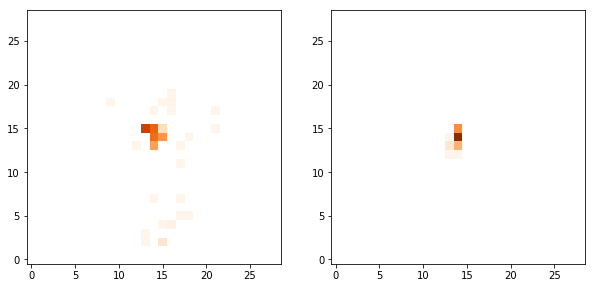

120.141928748


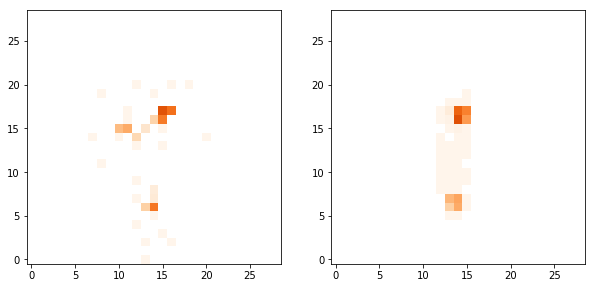

267.796379759


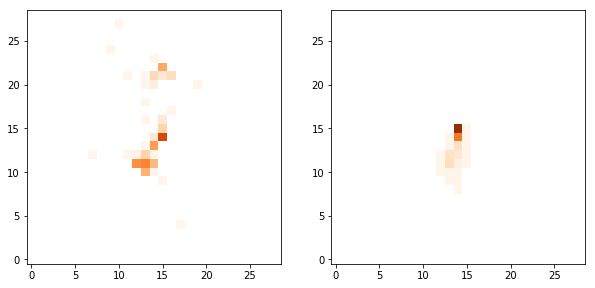

262.419188213


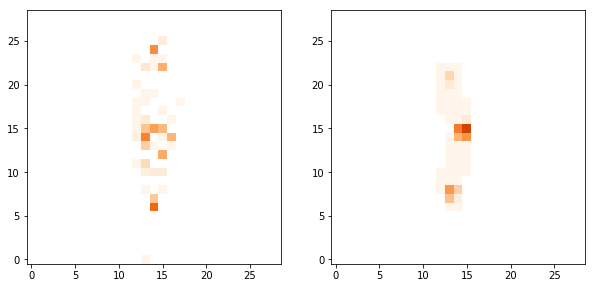

92.9528622793


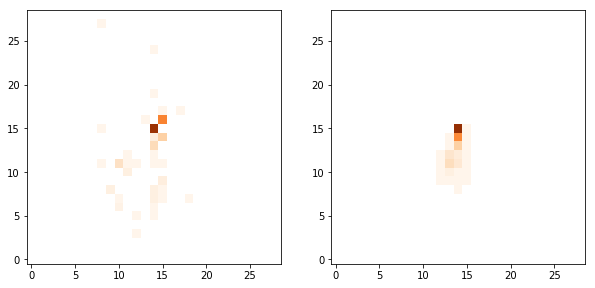

102.771871631


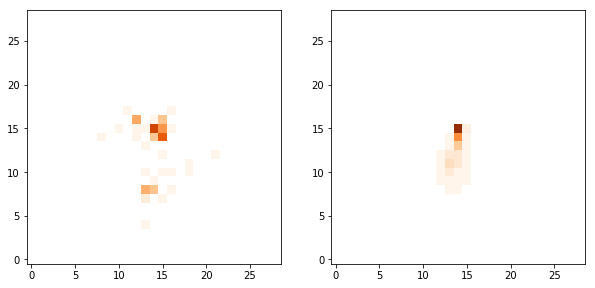

148.585388489


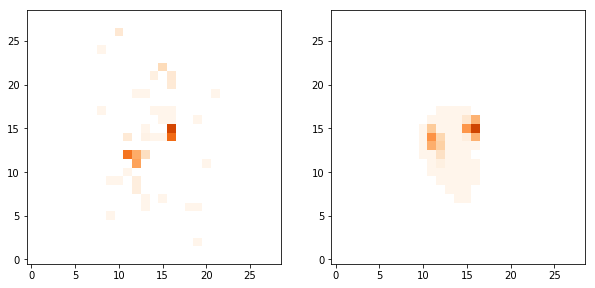

255.672425886


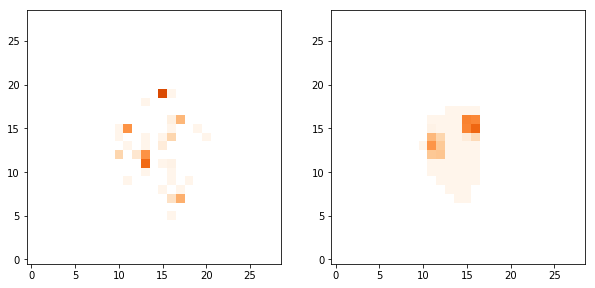

158.308735075


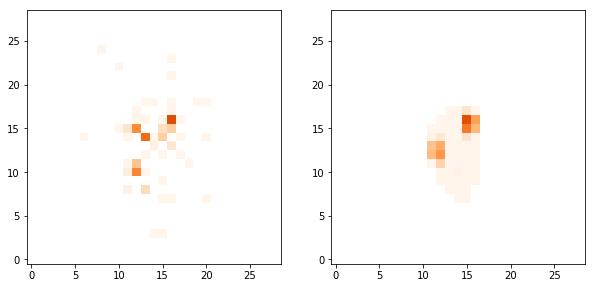

109.1959388


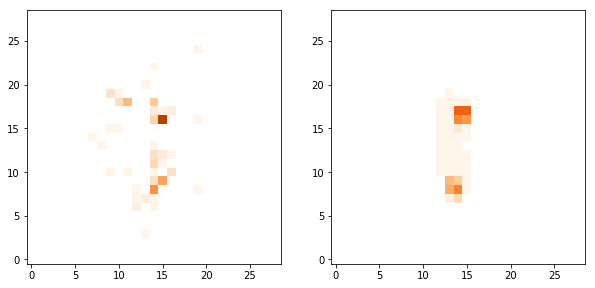

82.7051378507


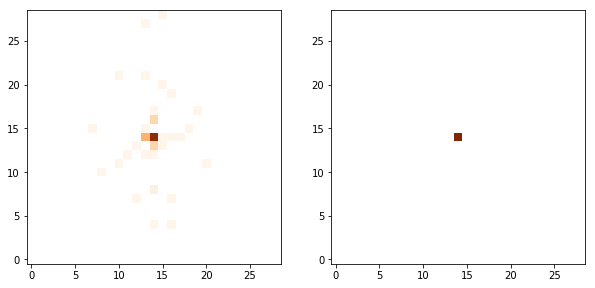

318.710649102


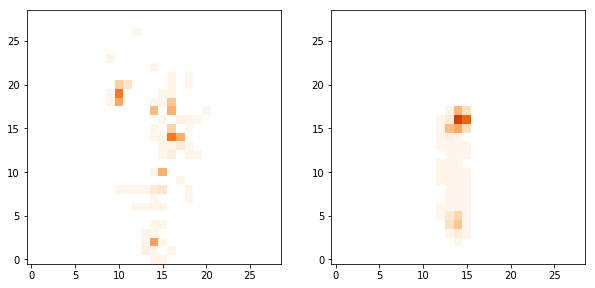

111.545295809


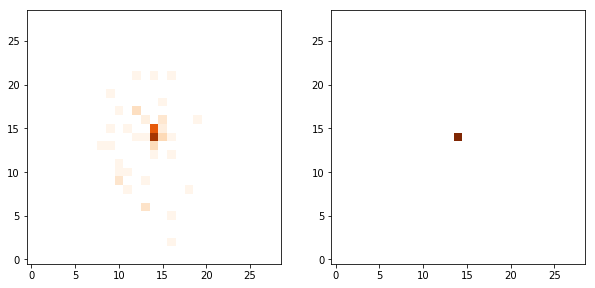

33.540730031


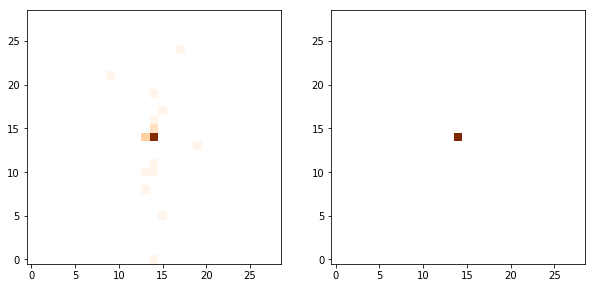

52.0644934904


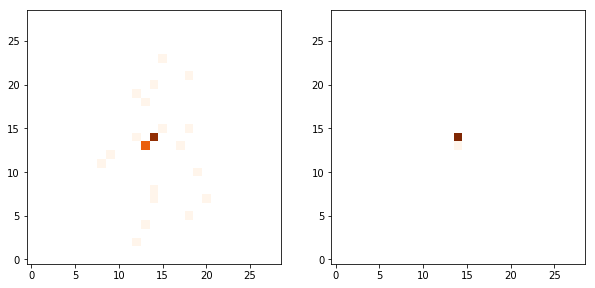

59.9774860697


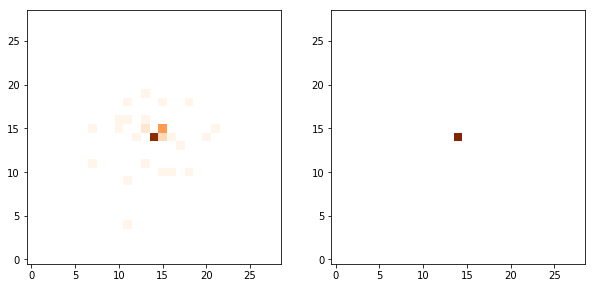

146.574630315


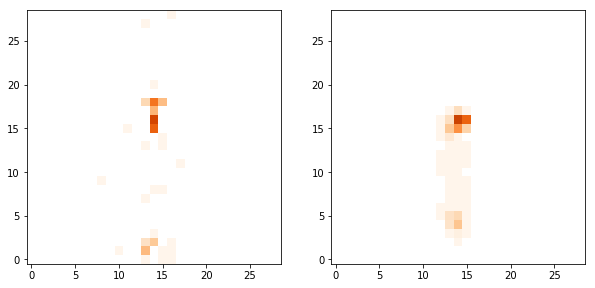

154.37243072


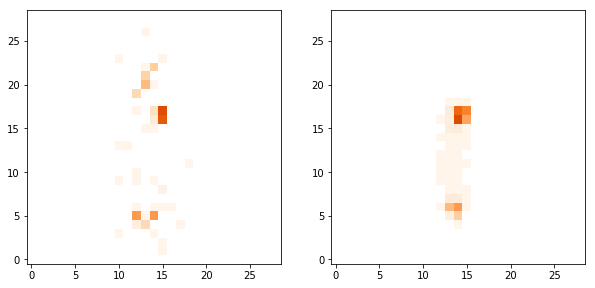

157.105544907


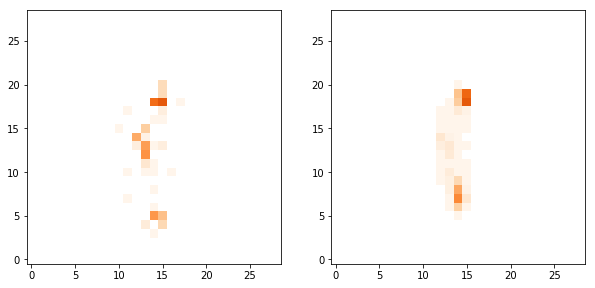

79.6571415431


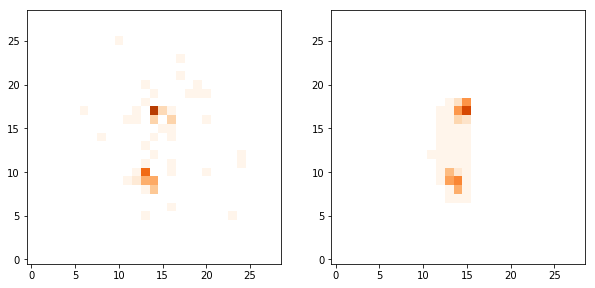

19.7728171867


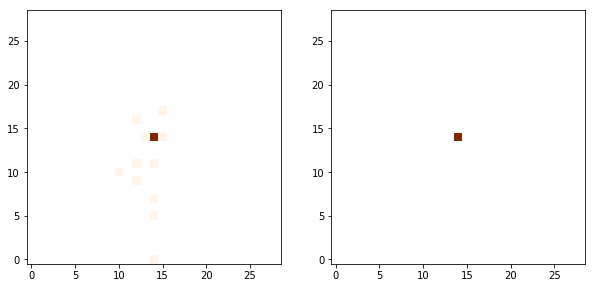

224.925069594


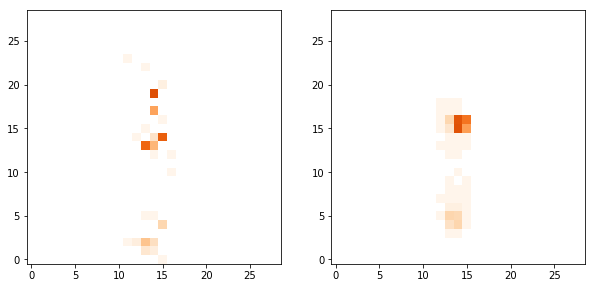

51.5541282434


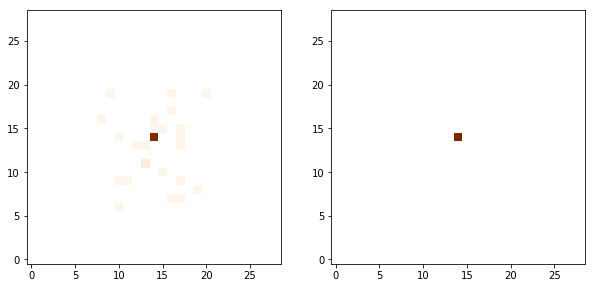

196.142908077


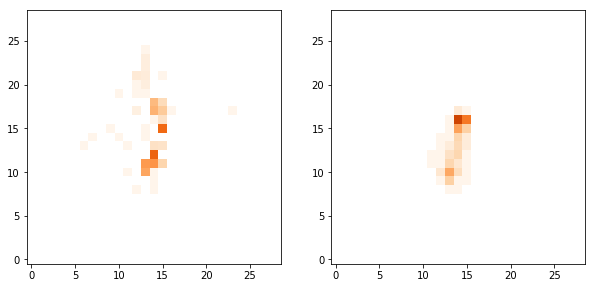

174.550315245


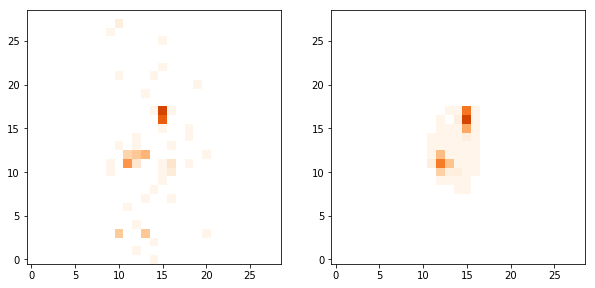

47.7604948418


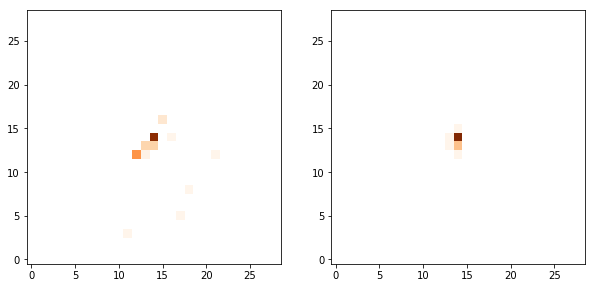

127.278418705


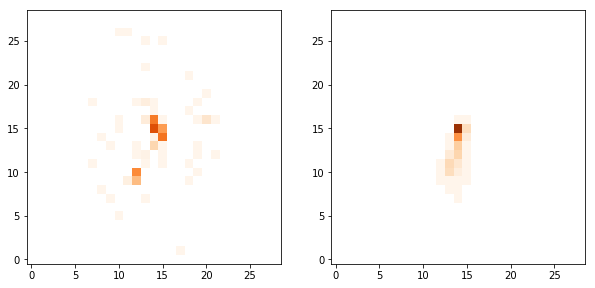

283.901403001


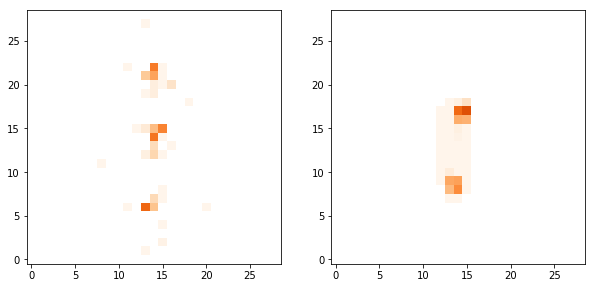

90.3275569545


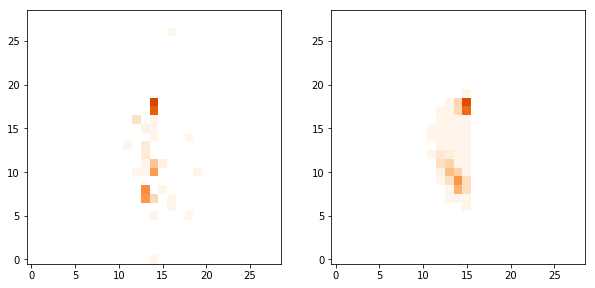

309.992837155


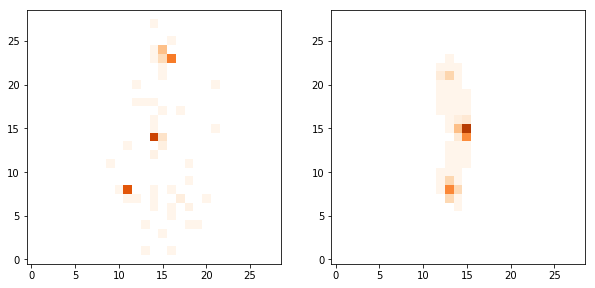

117.430217473


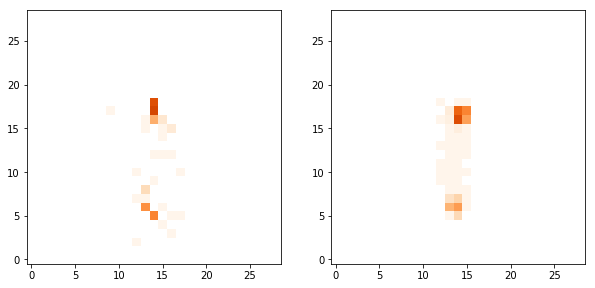

45.9683399916


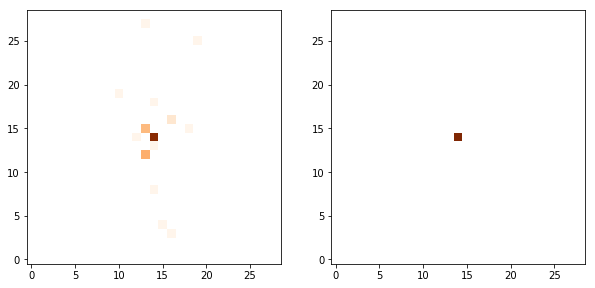

115.093876599


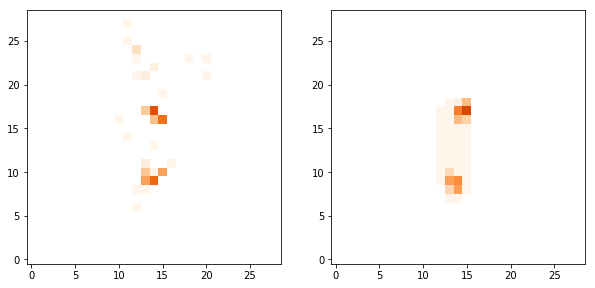

85.1634886677


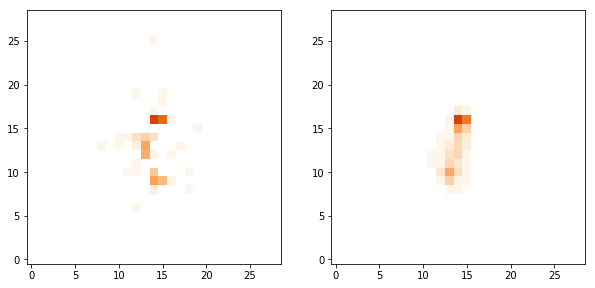

278.590604932


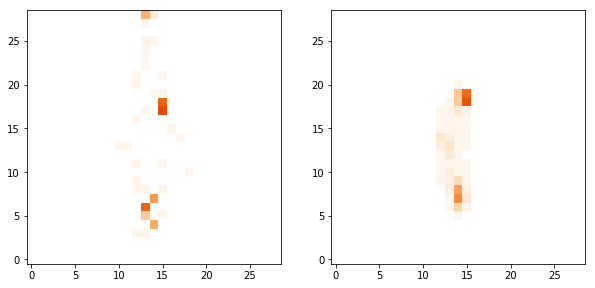

129.473948662


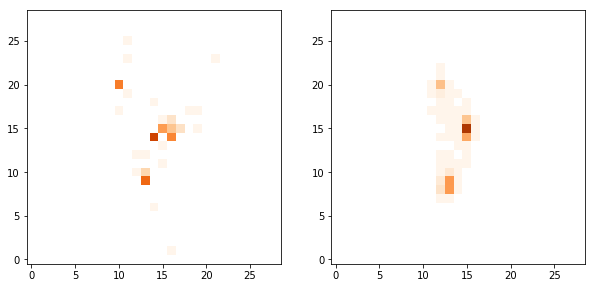

64.8796961524


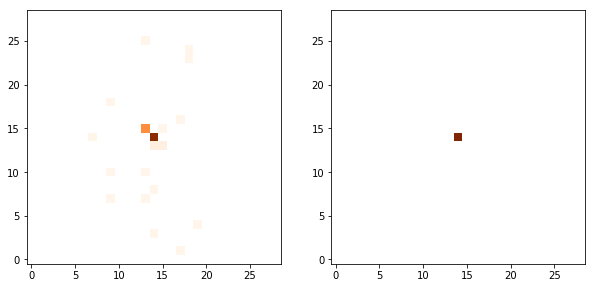

127.78610546


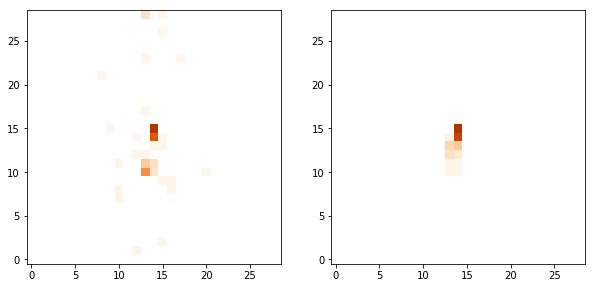

111.661731664


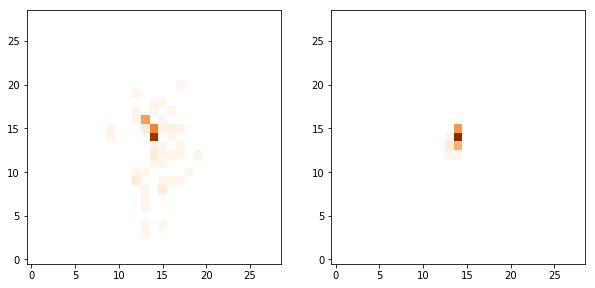

125.582650235


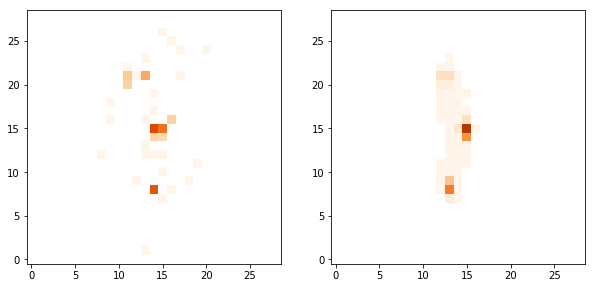

In [16]:
countcut=0.5
lim=1.5
bins=np.linspace(-lim, lim, 30)

for i in range(len(feed_pc)):
    

    M = np.sqrt(ot.dist(feed_pc[i],reconstructions[i]))
    truecost = ot.emd2(np.ones(1000),np.ones(1000),M)

    print truecost
    
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[0].imshow(counts.T , norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions[i][:,0],reconstructions[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[1].imshow(counts.T, norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [44]:
points1 = reconstructions[:100]
points2 = feed_pc[:100]

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])
print truecost
print time.time()-start

print np.average(truecost)
print np.std(truecost)

[ 92.55416573 177.33423311 176.77750437 199.57873757 162.14084442
  31.70353371 344.33884053  70.28503293 146.54488481 181.01449685
  65.83344885 260.10304735 226.30523966 218.77147155 177.30162145
 231.72665278 225.63748716 218.51085539 113.02358318  73.9379491
 113.32298101 141.53438525 183.36552015 111.2118607  121.34921628
  46.17607709 114.14157415 185.73461439  90.57208604 146.1305916
 146.92545318  83.16523368  80.30987069  71.13261096  96.51881587
 142.04785761 238.52894319  19.49459557  69.37013988 159.97450505
 171.34550366 121.4886048  153.11075026  87.1238423  146.44892496
  35.54913965  84.26328097 114.52329255 144.52120063 134.96318015]
7.13830709457
138.95536565571211
64.95862020444983


In [ ]:
import pandas as pd
numjets = 500000
numvalid = 50000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top.h5")
topdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
topdata = validdata.reshape(numvalid,1000,2)
top_pc_data = PointCloudDataSet(validdata,copy=False)
gc.collect()